In [1]:
import numpy as np
import pandas as pd

import scipy as sp
from scipy import linalg as la
from scipy import optimize
from scipy import stats
from scipy.stats import chisquare # not used

import matplotlib.pyplot as plt
import matplotlib as mpl


In [77]:
file = 'SouthCalifornia-1982-2011_Physics-of-Data.dat'
data = np.genfromtxt(file,
                     dtype=None,
                     delimiter=' ')
data.shape

(110271,)

In [78]:
df = pd.DataFrame(data)
df.columns = ['event', 'prev_event', 'time', 'magnitude', 'x', 'y', 'z']

# 0 - Understanding data

First of all we took a look at the dataset.

In [4]:
df.head()

,event,prev_event,time,magnitude,x,y,z
0,0,-1,0.00000,2.71,-2571956,-4627162,3520602
1,1,0,36501.39072,2.12,-2363740,-4787011,3461373
2,2,0,37488.27744,2.33,-2363746,-4786942,3461232
3,3,0,47982.51648,2.57,-2475085,-4664024,3548479
4,4,0,60268.57056,2.98,-2238642,-4839098,3469546


In [5]:
# we can see that the range of magnitudes is [2,7.3] 
# and that the measurement of time starts from 0 with the first event
df.describe()

,event,prev_event,time,magnitude,x,y,z
count,110271.000000,110271.000000,1.102710e+05,110271.000000,1.102710e+05,1.102710e+05,1.102710e+05
mean,55135.000000,35859.277625,4.262426e+08,2.457920,-2.388225e+06,-4.691072e+06,3.562612e+06
std,31832.640104,36365.001297,2.598605e+08,0.438374,8.878019e+04,1.237294e+05,1.271897e+05
min,0.000000,-1.000000,0.000000e+00,2.000000,-2.770239e+06,-5.020849e+06,3.186133e+06
25%,27567.500000,-1.000000,2.115783e+08,2.140000,-2.421620e+06,-4.801152e+06,3.458838e+06
50%,55135.000000,28462.000000,3.551023e+08,2.340000,-2.361829e+06,-4.699729e+06,3.564367e+06
75%,82702.500000,66972.000000,5.952398e+08,2.640000,-2.329898e+06,-4.615062e+06,3.634552e+06
max,110270.000000,110250.000000,9.305667e+08,7.300000,-1.998294e+06,-4.268289e+06,3.876120e+06


In [6]:
# not all the greatest earthquakes are without ancestors (we shall call them 'prime events')
df[df['magnitude']>6].sort_values(by = 'magnitude', ascending = False)

,event,prev_event,time,magnitude,x,y,z
39805,39805,39804,3.309144e+08,7.30,-2341818,-4710335,3575181
100065,100065,100062,8.915162e+08,7.20,-2294542,-4855348,3390238
75422,75422,75419,5.612489e+08,7.10,-2316706,-4693410,3609984
58367,58367,-1,3.799916e+08,6.70,-2508327,-4610300,3567642
22089,22089,21867,1.859399e+08,6.60,-2322573,-4795291,3462353
89331,89331,-1,6.932159e+08,6.48,-2662869,-4420508,3708948
39859,39859,39858,3.309257e+08,6.30,-2373276,-4692488,3573922
21867,21867,21866,1.858990e+08,6.20,-2316585,-4796535,3470023
37455,37455,37449,3.251864e+08,6.10,-2335795,-4723356,3549940
55532,55532,-1,3.588626e+08,6.10,-2364815,-4481227,3839436


# 1 - Data visualization

## 1.1 - Time distribution

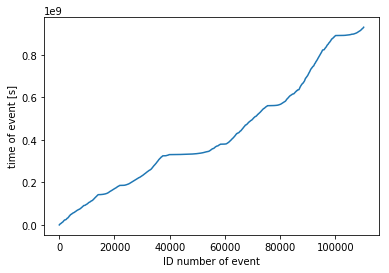

In [7]:
# just a routine look at the time distribution and time scale of the dataset 
%matplotlib inline

plt.plot(df['event'], df['time'])
plt.xlabel('ID number of event')
plt.ylabel('time of event [s]')
plt.show()

## 1.2 - Magnitude distribution

In [8]:
def my_expon(x, No, alpha):
    return No*np.exp(-alpha*x)

def my_log_expon(x, Q, alpha):
    return -alpha*x + Q

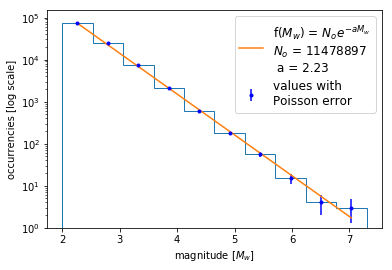

In [9]:
# here we can see how the magnitude is distributed as exp(-m)
n, bins, _ = plt.hist(df['magnitude'], log = True, histtype = 'step')
bin_centers = (bins[1:] + bins[:-1])/2
plt.errorbar(bin_centers, n, np.sqrt(n), fmt = '.b', label = 'values with \nPoisson error')

params1, _ = optimize.curve_fit(my_log_expon, bin_centers, np.log(n))
[Q, alpha] = params1
No = int(np.exp(Q))
plt.plot(bin_centers, my_expon(bin_centers, No, alpha), 
         label = 'f($M_w$) = $N_o$$e^{-aM_w}$ '+'\n$N_o$ = {}\n a = {}'.format(No,round(alpha,2)))

plt.xlabel('magnitude [$M_w$]')
plt.ylabel('occurrencies [log scale]')
plt.ylim(bottom = 1)
plt.legend(fontsize = 12)
plt.show()
plt.close()

# ADD NON LOGSCALE PLOT

## 1.3 - Spatial distribution 

In [10]:
from mpl_toolkits.mplot3d import Axes3D

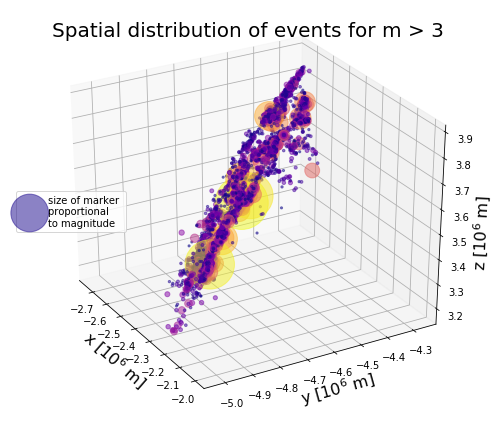

In [11]:
#az = [i*15 for i in range(24)]
#for azim in az:
#%matplotlib nbagg
m_bar = 3
dfm = df[df['magnitude'] > m_bar]
x_coord = dfm['x']
y_coord = dfm['y']
z_coord = dfm['z']
magnitude = dfm['magnitude']

fig = plt.figure(figsize = (7,6))
ax = fig.add_subplot(111, projection='3d')
ax.scatter(x_coord/1e06, y_coord/1e06, z_coord/1e06, 
           s=np.exp(magnitude*1.5)/np.exp(3), c = magnitude, marker="o", alpha = 0.5, 
           label = 'size of marker \nproportional \nto magnitude', cmap = 'plasma')
ax.set_xlabel("x [$10^6$ m]", fontsize = 16)
ax.set_ylabel("y [$10^6$ m]", fontsize = 16)
ax.set_zlabel("z [$10^6$ m]", fontsize = 16)
ax.set_title('Spatial distribution of events for m > 3', fontsize = 20)
ax.legend(loc = 'center left')
#print('azim = ', azim)
ax.view_init(elev = 30, azim = 330)

for spine in ax.spines.values():
    spine.set_visible(False)
    
plt.tight_layout()
plt.show()

### 1.3.1 PCA for spatial distribution

In [12]:
X = df[['x','y','z']].values.T
X = X.astype("float64")

# centering and rescaling the coordinates
for i in range(3):
    X[i] = (X[i] - X[i].mean())/X[i].std()

In [13]:
# PCA 
C = np.cov(X)
U, spectrum, Vt = la.svd(C)
print ('Spectrum: ', spectrum,'\n')
perc_expl2 = (spectrum[0] + spectrum[1]) / spectrum.sum()
print('Percent of the total variability explained considering the two main features: ', perc_expl2, '\n')

Spectrum:  [2.40189791e+00 5.96194962e-01 1.93433620e-03] 

Percent of the total variability explained considering the two main features:  0.9993552271146224 



As we can see above, the two largest eigenvalues can account for 99.9% of the total variability of the spatial coordinates; thus we can effectively conclude that the events are located on a plane.

## DA CAPIRE:
il piano è parallelo o "perpendicolare" (o trasversale) alla superficie terrestre? Basterebbe anche solo leggere qualcuno che l'ha già spiegato, dato che non è banale capirlo in queste coordinate. 

In the following panels we represent the two-dimensional projections of the spatial coordinates of the dataset both for the x,y,z frame and the $v_0, v_1, v_2$ frame (e.g. the one in the PCA coordinates); in the latter one we can see how the $v_2$ component is almost constant and all the relevant information is contained in the scatterplot $v_0$ vs $v_1$, that represents the projection of the original data along the eigenvectors associated to the two largest eigenvalues found in the PCA procedure. 

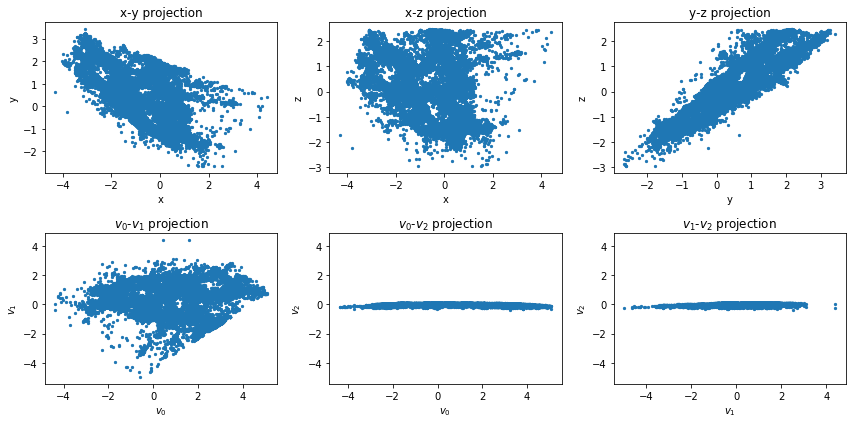

In [14]:
# projecting the data in the plane generated by the two eigenvectors with the largest eigenvalues
Xp = np.dot(Vt,X)

%matplotlib inline
# general plot of the PCA
fig, axes = plt.subplots(nrows=2, ncols=3,
                               figsize=(12, 6))

[[ax01, ax02, ax03],[ax11, ax12, ax13]] = axes

ax01.scatter(X[0], X[1], s= 5)
ax01.set_title('x-y projection')
ax01.set_xlabel('x')
ax01.set_ylabel('y')

ax02.scatter(X[0], X[2], s= 5)
ax02.set_title('x-z projection')
ax02.set_xlabel('x')
ax02.set_ylabel('z')

ax03.scatter(X[1], X[2], s= 5)
ax03.set_title('y-z projection')
ax03.set_xlabel('y')
ax03.set_ylabel('z')

ax11.scatter(Xp[0], Xp[1], s= 5)
ax11.set_title('$v_0$-$v_1$ projection')
(y_bottom, y_top) = ax11.get_ylim()
ax11.set_xlabel('$v_0$')
ax11.set_ylabel('$v_1$')

ax12.scatter(Xp[0], Xp[2], s= 5)
ax12.set_ylim(y_bottom, y_top)
ax12.set_title('$v_0$-$v_2$ projection')
ax12.set_xlabel('$v_0$')
ax12.set_ylabel('$v_2$')

ax13.scatter(Xp[1], Xp[2], s= 5)
ax13.set_ylim(y_bottom, y_top)
ax13.set_title('$v_1$-$v_2$ projection')
ax13.set_xlabel('$v_1$')
ax13.set_ylabel('$v_2$')

plt.tight_layout()
plt.show()

# ABBELLIRE -> fontsize maggiore, magari inserire lieve trasparenza per visualizzare anche la densità di eventi

## COMMENTO KDE: 
onestamente non so cosa ci dica questo grafico, io mi aspettavo di vedere le faglie sulla KDE di destra, che invece sembra molto più uniforme della KDE in alto. Secondo me la direzione di maggiore varianza (autovalore maggiore) è Xp[0] e mi sembra quella parallela alle faglie, non quella trasversale; però la KDE in alto sembra proprio quella che intuitivamente mi sarei aspettato "schiacciando" le faglie in un istogramma... Sarebbe da verificare plottando nello spazio originale il vettore associato all'autovalore maggiore (volendo anche al secondo) e vedere se è parallelo o trasversale alle faglie. Se non sappiamo spiegarci la KDE e non ci aiuta a spiegare nulla, la toglierei.

/home/nicola/anaconda3/lib/python3.7/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


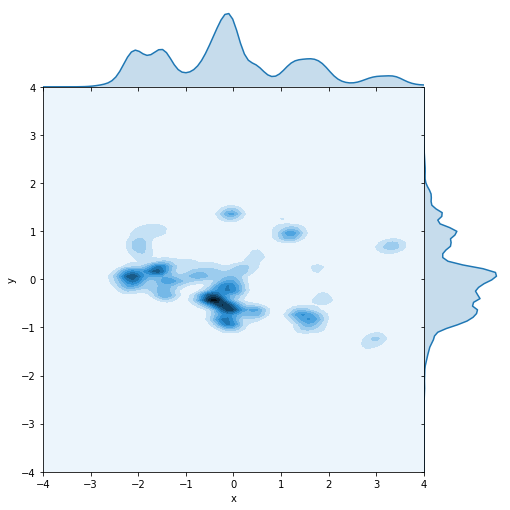

In [15]:
import seaborn as sns
# Show the joint distribution using kernel density estimation
g = sns.jointplot(Xp[0], Xp[1], kind="kde", xlim=[-4,4], ylim=[-4,4], height=7, space=0)
g.set_axis_labels(xlabel='x', ylabel='y')

Going back to the x,y,z frame, we can see in a trasversal view how the plane that corresponds to the eigenspace of the two largest eigenvectors fits the data. This is further evidence of the PCA efficacy.

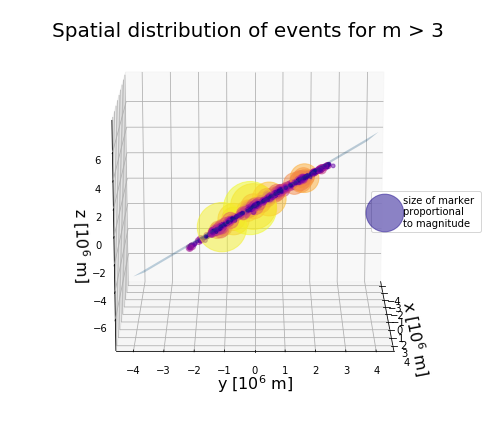

In [16]:
[v1, v2, v3] = Vt
normal = v3
xx, yy = np.meshgrid(range(-4,5), range(-4,5))# calculate corresponding z
z = (-normal[0] * xx - normal[1] * yy ) * 1. /normal[2]

m_bar = 3
dfm = df[df['magnitude'] > m_bar]
x_coord = dfm['x']
y_coord = dfm['y']
z_coord = dfm['z']
x_coord = (x_coord - x_coord.mean())/x_coord.std()
y_coord = (y_coord - y_coord.mean())/y_coord.std()
z_coord = (z_coord - z_coord.mean())/z_coord.std()
magnitude = dfm['magnitude']

#%matplotlib nbagg

fig = plt.figure(figsize = (7,6))
ax = fig.add_subplot(111, projection='3d')
ax.plot_surface(xx, yy, z, alpha=0.3)
ax.scatter(x_coord, y_coord, z_coord, 
           s=np.exp(magnitude*1.5)/np.exp(3), c = magnitude, marker="o", alpha = 0.5, 
           label = 'size of marker \nproportional \nto magnitude', cmap = 'plasma')
ax.set_xlabel("x [$10^6$ m]", fontsize = 16)
ax.set_ylabel("y [$10^6$ m]", fontsize = 16)
ax.set_zlabel("z [$10^6$ m]", fontsize = 16)
ax.set_title('Spatial distribution of events for m > 3', fontsize = 20)
ax.legend(loc = 'center right')
#print('azim = ', azim)
ax.view_init(elev = 15, azim = 0)
for spine in ax.spines.values():
    spine.set_visible(False)

plt.tight_layout()
plt.show()

In [17]:
plt.close()
%matplotlib inline

Finally we plotted a heatmap of the events using as coordinates the first and the second principal components, to visualize the density of events in those coordinates. The color is brighter where the density is higher, with a scale of colors that is logaritmic in the occurrencies of each cell. 

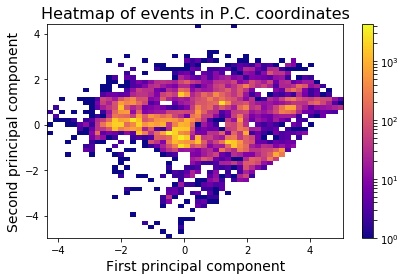

In [72]:
from matplotlib.colors import LogNorm
plt.figure(211)

plt.hist2d(Xp[0], Xp[1], bins = 50, norm = LogNorm(), cmap = "plasma")
plt.colorbar()
plt.xlabel('First principal component', fontsize = 14)
plt.ylabel('Second principal component', fontsize = 14)
plt.title('Heatmap of events in P.C. coordinates', fontsize = 16)
plt.tight_layout()
plt.show()
plt.close()

## 1.4 - Tree architecture

Here we want to exploit the information contained in the 'prev_event' column in order to be able to compute quantities such as distance and waiting time between an event and his ancestor.

First of all we iteratively created a nested dictionary, containing as keys the IDs of the primes events (i.e. the ones labelled with 'prev_event' = 1) and as values a dictionary with:
* the "depth" of the event in the cause-effect chain (i.e. 0 for the prime events, 1 for the ones caused by them, 2 for the ones caused by events of depth 1 and so on so forth);
* the "children" of that event, i.e. the events that have as prev_event the id of the event considered; "children" value contains itself a dictionary like the one just described for the prime events, hence the nested structure.

In [19]:
def evees_light(df, index=-1, depth=0):
    dataset = {}
    df_filtered = df[df["prev_event"]==index]
    lenght =  df_filtered.shape[0]
    for i in range(lenght):
        event = df_filtered.iloc[i]
        dataset[str(int(event["event"]))] = {"depth" : depth}
        dataset[str(int(event["event"]))]["children"] = evees_light(df, index=int(event["event"]), depth = depth + 1)
    return dataset

Then we mapped the dictionary so obtained in a list of dictionaries, whose indexes are the depth of the events (ranging from 0 to max_depth, that is unknown a priori); the entry of the list of index i is a dictionary that has as keys the IDs of the events of depth = i and as values the IDs of its children.

In [20]:
def write_dict_array(dataset, dict_array):
    for k in dataset.keys():
        depth = dataset[k]['depth']
        # k is the keyword, children_ids are the values
        if len(dict_array) < depth + 1 :
            while len(dict_array) < depth + 1:
                dict_array.append({})
        else:
            dict_array[depth][k] = list(dataset[k]['children'].keys())
        if len(list(dataset[k]['children'].keys())) != 0:
            write_dict_array(dataset[k]['children'], dict_array)

In [21]:
tree_dataset = evees_light(df)
v_dict = [{}]
write_dict_array(tree_dataset, v_dict)

Now we use the list of dictionaries to add the depth and the number of children (or number of edges if we think of the dataset as an oriented graph) of each event by adding two columns to the original dataset.

In [22]:
N = df.shape[0]
edges = np.zeros(N)
depths = np.zeros(N)

for d in range(len(v_dict)):
    for k in v_dict[d].keys():
        #print(k)
        edges[int(k)] = len(v_dict[d][k])
        depths[int(k)] = d
        
df['edges'] = edges
df['depth'] = depths

In [23]:
# From the new features we can see an interesting thing: the event with the highest magnitude (7.3) is not prime 
# (because it hasn't prev_event = -1), but it happend after a concatenation of 11 earthquakes and subsequently caused 
# other 4209 events!
df[df['magnitude'] == 7.3]

,event,prev_event,time,magnitude,x,y,z,edges,depth
39805,39805,39804,3.309144e+08,7.3,-2341818,-4710335,3575181,4209.0,11.0


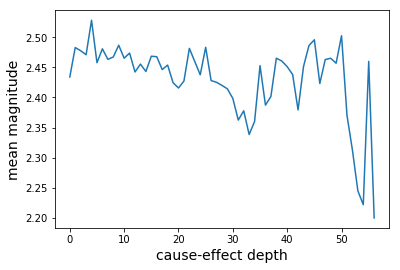

In [24]:
# Furthermore we can see that depth isn't a good indicator of magnitude and that in fact one can't find any relation
# between the two
mean_mag = df.groupby('depth')['magnitude'].mean()
depth_axis = [i for i in range(len(mean_mag))]
plt.plot(depth_axis, mean_mag)
plt.xlabel('cause-effect depth', fontsize = 14)
plt.ylabel('mean magnitude', fontsize = 14)
plt.show()

# ABBELLIRE

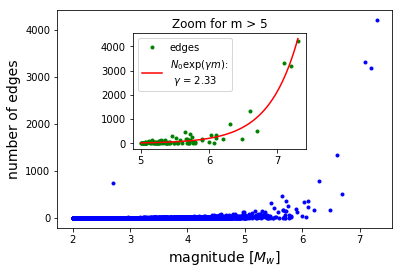

In [25]:
# as we could expect the events with higher magnitudes have much more edges than the ones with lower magnitudes. 
# In fact the dependence is exponential with m

def my_expon1(x, No, gamma):
    return No*np.exp(gamma*x)

plt.plot(df['magnitude'], df['edges'] , '.b')
plt.xlabel('magnitude [$M_w$]', fontsize = 14)
plt.ylabel('number of edges', fontsize = 14)

df5 = df[df['magnitude'] > 5]
ax = plt.axes([0.3, 0.4, 0.4, 0.4])
ax.set_title('Zoom for m > 5')
ax.plot(df5['magnitude'], df5['edges'] , '.g')
params1, _ = optimize.curve_fit(my_expon1, df5['magnitude'], df5['edges'])
[No, gamma] = params1
x_axis = np.linspace(5,7.3,100)
ax.plot(x_axis, my_expon1(x_axis, *params1), 'r-', 
        label = '$N_0$exp($\gamma m$):\n $\gamma$ = {}'.format(round(gamma,2)))
ax.legend()
    
plt.show()

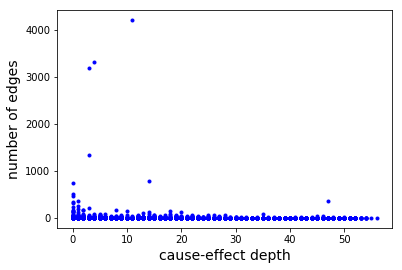

In [26]:
# again depth isn't a good indicator of edges (as it wasn't for magnitude)
plt.plot(df['depth'], df['edges'], 'b.')
plt.xlabel('cause-effect depth', fontsize = 14)
plt.ylabel('number of edges', fontsize = 14)
plt.show()

# 2 - Distribution of waiting time 
Compute the distribution $P_m(t)$ of waiting times for events of magnitude m or above (i.e. do not consider events below $m$). In shaping the bin sizes, take into account that this distribution is expected to have a power-law decay with time (e.g $\sim 1/t$), and that a power-law is well visualized in log-log scale. Do this analysis for many values of $m$, say $m=2,3,4,5$.

In [73]:
def binning(x, rescaling = False, density = False):
    
    """Binning for power laws distributions.
        x = entries generated from a power law."""
    
    # x must have streactly positive values; x isn't normalized in general
    x = x[x>0]
    if rescaling == True:
        x = x/x.max()
        
    x.sort()
    
    # empirical method to get a good amount of bins (min 8, max 16), depending on the number of samples
    bin_extremes_number = max( min( int( np.log(len(x))*2 ) , 17), 9) 
    
    # choose the right extreme of the first bin as the one that corresponds to N/bin_extreme_number of samples in the
    #first bin
    first_quantile = x[int(x.shape[0]*(1/bin_extremes_number))]
    
    # create bins whose widths are constant in the logaritmic scale 
    bin_extremes = np.logspace(np.log10(first_quantile), np.log10(x.max()), bin_extremes_number)
    #and then concatenate 0 as a starting point for the first bin
    bin_extremes = np.concatenate((np.array([0]), bin_extremes))

    widths = bin_extremes[1:] - bin_extremes[:-1]
    centers = (bin_extremes[1:] + bin_extremes[:-1])/2
    
    freq, _, _ = plt.hist(x, bins=bin_extremes)
    plt.close()
    
    # having unhomogeneous bins the frequencies must be divided for the width of the corresponding bin in order
    # to get an estimator of the probability density in each point (~ bin center), i.e. :
    # weights(bin_center) = Prob(bin_center) , if normalized = True
    weights = freq/widths
    # poissonian errors for the frequencies, then the error is propagated to the weights dividing elementwise for
    # the widths
    sigma_weights = np.sqrt(freq)/widths
    
    # merging of the first two bins until we get that the first bin represents the max of the PDF 
    # this is a useful option to regularize the first bin if we expect it to assume the highest value
    while weights[0] < weights[1]:
        print('Merging first and second bins.')
        #this is done by removing the second extreme, thus the first bin becomes the one between 0 and 2
        bin_extremes = np.concatenate(([bin_extremes[0]], bin_extremes[2:] ))
        widths = bin_extremes[1:] - bin_extremes[:-1]
        centers = (bin_extremes[1:] + bin_extremes[:-1])/2
        
        # then of course we need to recompute frequencies and weights for the new bins
        freq, _, _ = plt.hist(x, bins=bin_extremes)
        plt.close()
        weights = freq/widths
        sigma_weights = np.sqrt(freq)/widths
        
    # adding also the merging of empty bins with the one on the left
    # this avoids the issue of taking the log of 0 in the log-log space where we perform the linear regression
    mask = (freq != np.zeros(len(freq)))
    flag = np.all(mask)
    # should enter in the while loop only in there is at least one bin without counts in it
    
    while flag == False:
        print('Entered in the while loop.')
        print('Original frequencies: ', freq)
        for i in range(1,len(freq)):
            if freq[i] == 0:
                print('Merging bin {} (empty) with bin {}.'.format(i,i-1))
                # bin extremes should be of length len(freq) + 1
                # notice that bin_extremes[i] corresponds to the right border of bin[i-1]
                # bin_extremes[:i] excludes the bin_extreme[i] !
                bin_extremes = np.concatenate((bin_extremes[:i], bin_extremes[i+1:] ))
                widths = bin_extremes[1:] - bin_extremes[:-1]
                centers = (bin_extremes[1:] + bin_extremes[:-1])/2
                # call a break of the for because the len frequence changes and can result in index errors
                break
                
        # update of the frequencies

        freq, _, _ = plt.hist(x, bins=bin_extremes)
        plt.close()
        weights = freq/widths
        sigma_weights = np.sqrt(freq)/widths
        
        # update of the exit condition
        mask = (freq != np.zeros(len(freq)))
        flag = np.all(mask)
 
    if density == True:
        #returns normalized weights (with rescaled errors) so that the area of the histogram is 1
        area = np.sum(weights*widths)
        weights = weights / area
        sigma_weights = sigma_weights/area
    
    return bin_extremes, widths, centers, freq, weights, sigma_weights   

In [28]:
def linear_f(x, p, q):
        return p*x+q

def loglog_fitting(x, y, skip_initial_pt = 1, cut_off = False, P0 = 3 ):
    from scipy import optimize
    
    # this is used because the first bin is always problematic: in the log space log(0) doesn't exist, but in the 
    # original space it is the only non-arbitrary lower bound to the values that are acceptable both for the waiting times
    # and the distances. Thus by default we ignore the first point in the regression
    x = x[skip_initial_pt:]
    y = y[skip_initial_pt:]
    
    if cut_off == False:
        params, cov = optimize.curve_fit(linear_f, x, y)
        [p,q] = params
        return p, q, cov
    
    else:
        #notice that we are already working without considering the first skip_initial_pt points
        mean_squared_res = []    
        predicted_squared_res = []
        
        # P is the number of points considered for the fit, used for testing whether the point P+1 is alligned
        # with them or not; the likelihood of not being alligned is given by the ratio between 
        # the predicted squared residual of point P+1 (based on the fit on the previous P points) 
        # and the mean squared residual computed for the P points 
        # P0 is the minumum amount of points that we require to be aligned "a priori" and it is used to calibrate
        # the notion of alligned/not-alligned for the fit (more points, like 5, make the algorithm more stable w.r.t.
        # statistical fluctuations)
        for P in range(P0,len(x)):
            params, cov = optimize.curve_fit(linear_f, x[:P], y[:P])
            [p,q] = params

            squared_residuals = np.power(y[:P] - linear_f(x[:P], *params),2)
            mean_squared_res.append(squared_residuals.mean())
            
            next_pt_squared_res = np.power(y[P] - linear_f(x[P], *params),2) 
            predicted_squared_res.append(next_pt_squared_res)
            
        predicted_squared_res = np.array(predicted_squared_res)
        mean_squared_res = np.array(mean_squared_res)
        predicted_vs_mean_ratio = predicted_squared_res/mean_squared_res
        predicted_vs_mean_ratio_norm = predicted_vs_mean_ratio/predicted_vs_mean_ratio.max()
    
        # The index of the array predicted_vs_mean_ratio_norm is shifted by P0 positions, meaning that we consider
        # as the maximal number of alligned points the one corresponding to the index of the max of 
        # predicted_vs_mean_ratio_norm + P0 = good_points. 

        indexes = np.arange(P0,len(x))
        max_index = indexes[predicted_vs_mean_ratio_norm == predicted_vs_mean_ratio_norm.max()]
        good_points = max_index[0]
        print('Good points {} out of {}'.format(good_points, len(x)))
        # Then the cut-off is estimated as x_cut = (x[good_points]+ x[good_points+1])/2
        if good_points < len(x):
            # the -1 shift at the index is because the index numeration starts at 0
            x_cut = (x[good_points-1]+ x[good_points])/2
        else:
            print('ATTENTION: all points seem alligned.')
            print('x_cut set to the value of the last point.')
            x_cut = x[-1]
            
        params, cov = optimize.curve_fit(linear_f, x[:good_points], y[:good_points])
        [p,q] = params
        
        return p, q, cov, x_cut
    

In [74]:
def plot_powerlaw_hist(x, rescaling = False, density = False, show = True, **kwargs):
    
    # compute automatically a suitable binning for x and all the associated quantities
    bin_extremes, widths, centers, freq, weights, sigma_weights = binning(x, rescaling, density)
    bin_number = len(centers)
    
    if show:
        fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2,figsize=(11, 5))
        
        # we plot a single point for each bin with the weight being the probability density estimated for the center 
        # of the bin (see binning function)
        ax1.hist(centers, bins = bin_extremes, weights = weights, histtype = 'step')
        ax1.errorbar(centers, weights, sigma_weights, fmt = 'r.')
        ax1.set_xscale('log')
        ax1.set_yscale('log')
        ax1.set_xlabel('waiting times [s]', fontsize = 14)
        ax1.set_ylabel('occurrencies [a.u]', fontsize = 14)
        ax1.set_title('Number of events = {}'.format(len(x)))
    
    # now we need to fit the power law in the log-log space, eventually identifying the points before the cut-off
    # this should work automatically both for the case rescaling = True or False (if True, x is in [0,1]) 
    # and for the case density = True or False (if True, the area of the histogram is normalized to 1 
    # and the weights are rescaled so that np.sum(weights*bin_widths) = 1)
    log_x = np.log(centers)
    log_w = np.log(weights)
    
    # the idea is to write a function that as a default just fits the (log_x,log_w) with a linear function 
    # log_w = p*log_x + q and has 2 flags: one for excluding skip_initial_pt points (set to 1 for default because
    # the first bin is always problematic) and another one to signal that we expect a cut-off at the right side of the
    # distribution (i.e. the tail) and we want to stop fitting just before the cut-off.
    # we want as a return the parameters p and q with their covariance matrix (that is the default return of 
    # scipy curve_fit) and, if the cut_off flag is True, also the estimate cut-off (rescaled or not depending on the 
    # setting passed before)
    
    if 'cut_off' in kwargs:
        if kwargs['cut_off'] == True:
             p, q, cov, log_x_cut = loglog_fitting(log_x, log_w, **kwargs)
    else:
        p, q, cov = loglog_fitting(log_x, log_w, **kwargs)
    
    if show:
        y_errors = sigma_weights/weights

        ax2.errorbar(log_x, log_w, yerr = y_errors ,fmt ='r.', label = 'entries with errors')
        ax2.plot(log_x, linear_f(log_x, p, q), 
                 label = 'f(x) = px + q\np = {} \nq = {}'.format(round(p,1),round(q,1)))
        ax2.legend()
        ax2.set_xlabel('waiting times [logscale]', fontsize = 14)
        ax2.set_ylabel('occurrencies [logscale]', fontsize = 14)

        plt.show()
    
    if 'cut_off' in kwargs:
        if kwargs['cut_off'] == True:
            if rescaling == True:
                return p, q, np.sqrt(cov[0,0]), np.exp(log_x_cut)*x.max()
            else:
                return p, q, np.sqrt(cov[0,0]), np.exp(log_x_cut)
    else:
        # returns the slope, the intercept and the error of the slope
        return p, q, np.sqrt(cov[0,0])


Time distribution for m =  2.0 

Good points 13 out of 16


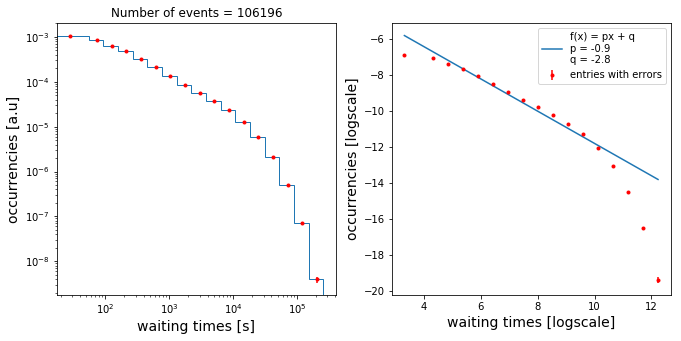


Time distribution for m =  2.25 

Good points 12 out of 16


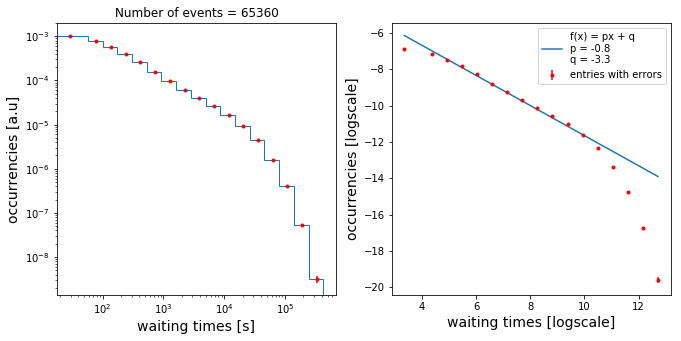


Time distribution for m =  2.5 

Good points 13 out of 16


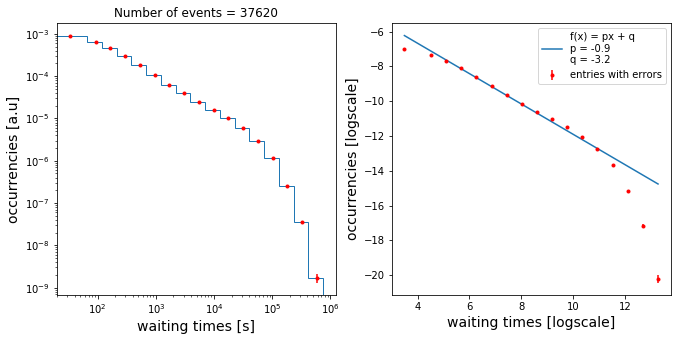


Time distribution for m =  2.75 

Good points 13 out of 16


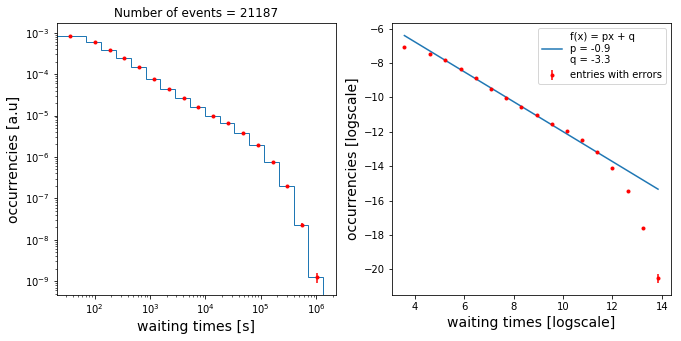


Time distribution for m =  3.0 

Good points 14 out of 16


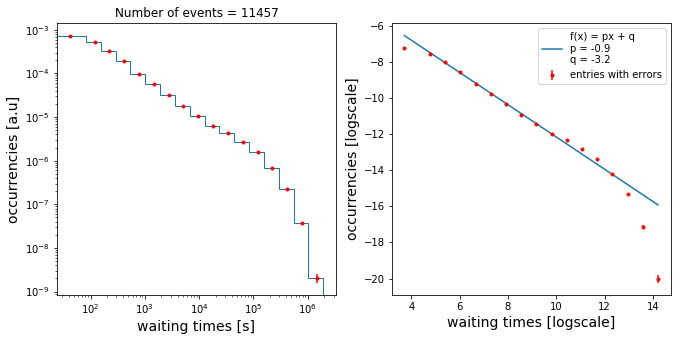


Time distribution for m =  3.25 

Good points 14 out of 16


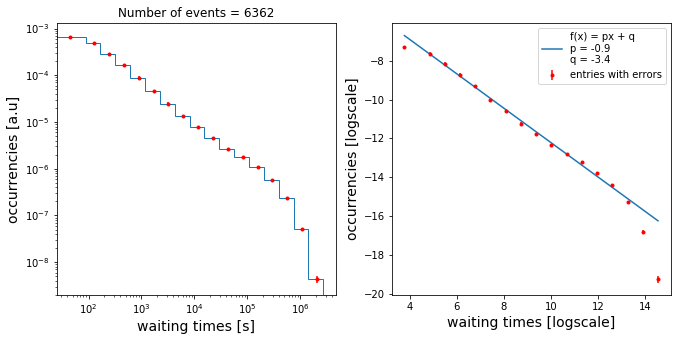


Time distribution for m =  3.5 

Good points 14 out of 15


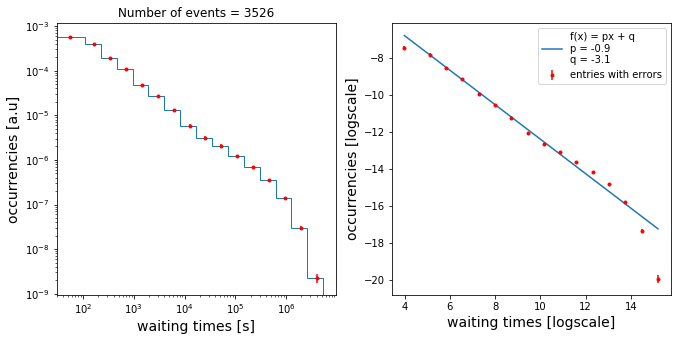


Time distribution for m =  3.75 

Good points 13 out of 14


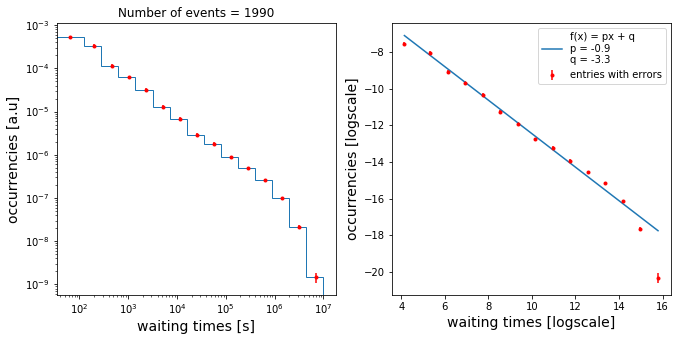


Time distribution for m =  4.0 

Good points 12 out of 13


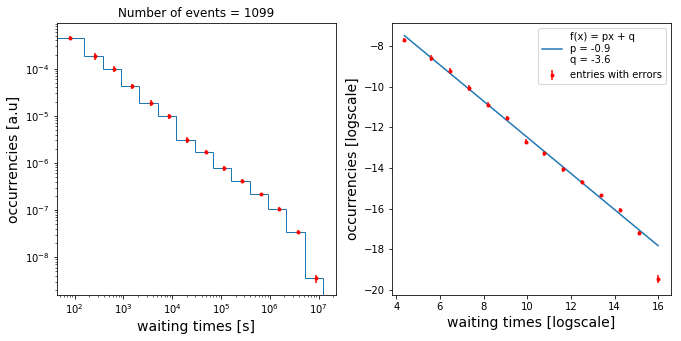


Time distribution for m =  4.25 

Good points 10 out of 11


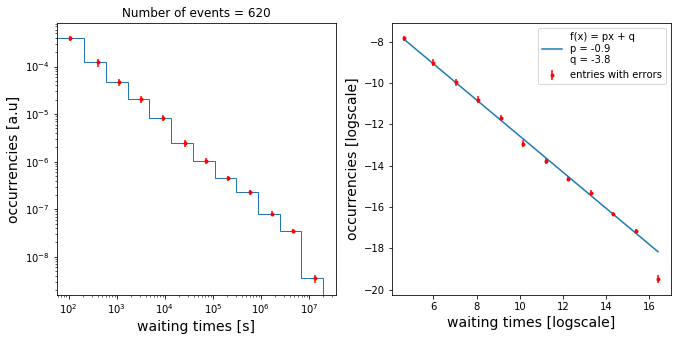


Time distribution for m =  4.5 

Good points 9 out of 10


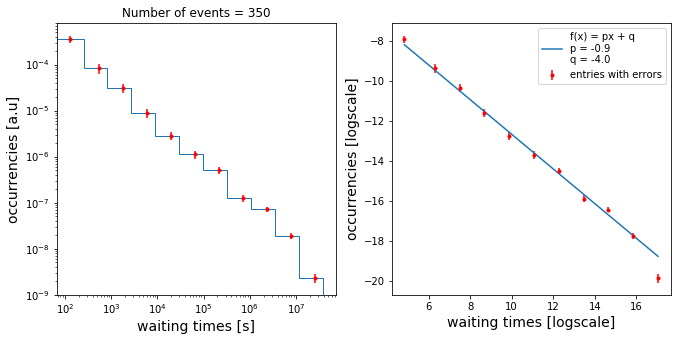

In [79]:
# we choose to study the data for m between 2 and 4.5, because above 5 we get just 104 samples 
# and there isn't enough information to fit anything but the initial peak of the distribution.
ms1 = np.linspace(2,4.5,11)
p_time = np.zeros(len(ms1))
q_time = np.zeros(len(ms1))
p_t_errors = np.zeros(len(ms1))
cut_times = np.zeros(len(ms1))

for i in range(len(ms1)):

    m = ms1[i]
    print('\nTime distribution for m = ', m, '\n')
    # waiting time for events of magnitude > m
    dfm = df[df['magnitude'] > m]
    timem = np.array(dfm['time'])
    timem.sort()
    time_d = timem[1:] - timem[:-1]
    
    # eliminating a couple of anomalous events
    temp = time_d[time_d != time_d.max()]
    maximum = temp.max()
    if time_d.max()*3/4 > maximum:
        time_d = temp

    p_time[i], q_time[i], p_t_errors[i], cut_times[i] = plot_powerlaw_hist(time_d, rescaling = False, 
                                                                   density = True, cut_off = True, P0 = 5)

From the analysis of the p exponent of $P(t) \propto t^p$ we can't find any significant pattern in the dipendence from the magnitude.

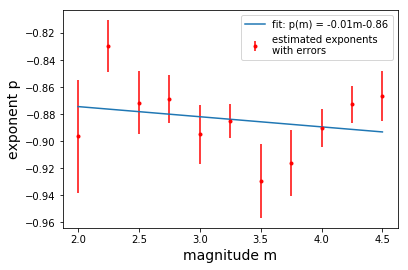

In [31]:

slope, intercept, r_value, p_value, std_err = stats.linregress(ms1, p_time)
plt.errorbar(ms1, p_time, yerr = p_t_errors, fmt = '.r', label = 'estimated exponents \nwith errors' )
plt.plot(ms1, intercept+slope*ms1, label = 'fit: p(m) = %.2fm%.2f'%(slope,intercept))
plt.ylabel('exponent p', fontsize = 14)
plt.xlabel('magnitude m', fontsize = 14)
plt.legend()
plt.show()

Instead the cut-off time has an exponential dependence from the magnitude. We will see in the last section how this relation can be used for a rescaling procedure that collapses the distributions of the waiting times for each magnitude to a single, magnitude-independent, distribution.

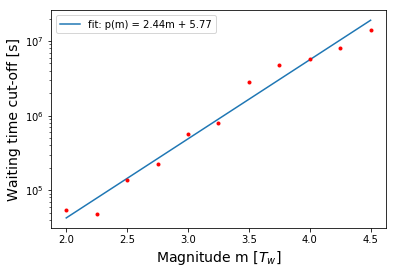

In [32]:
slope, intercept, r_value, p_value, std_err = stats.linregress(ms1, np.log(cut_times))
predicted_cut_times = np.exp(intercept+slope*ms1)
plt.plot(ms1, predicted_cut_times, label = 'fit: p(m) = %.2fm + %.2f'%(slope,intercept))

plt.errorbar(ms1, cut_times, fmt = '.r')
plt.ylabel('Waiting time cut-off [s]', fontsize = 14)
plt.xlabel('Magnitude m [$T_w$]', fontsize = 14)
plt.yscale('log')
plt.legend()
plt.show()


## NOTA: 
io toglierei tutta la parte qui sotto, sia per i concatenated events che per i prime events, perché tanto il caso con tutti gli eventi funziona già bene (meglio) di suo.

### 2.2 - Waiting time distribution between concatenated events - REMOVE

We now analyze the distribution of waiting times but considering only the waiting times between an event and the ancestor.

In [33]:
# REMOVE
time_diff_tree = np.zeros(N)

for d in range(len(v_dict)):
    for k in v_dict[d].keys():
        # previous vertex has id = k, children vertexes have ids [ v_dict[d][k] ]
        for j in v_dict[d][k]:
            #print('Computing {}-> {} waiting time.'.format(k,j))
            time_diff_tree[int(j)] = df['time'].iloc[int(j)] - df['time'].iloc[int(k)]
            
time_diff_tree = time_diff_tree[time_diff_tree > 0]

Good points 3 out of 16


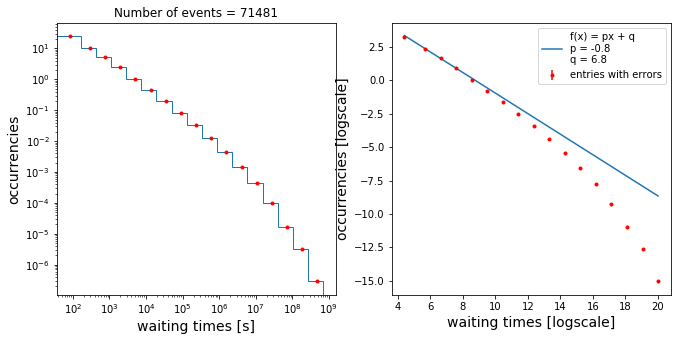

In [34]:
p_tree, q_tree, p_tree_err, cut_time_tree = plot_powerlaw_hist(time_diff_tree, rescaling = False, 
                                                                   density = False, cut_off = True)

We can see that the waiting time distribution of consequent events displaces a behaviour similar to the more general case seen above, i.e. a power law with a cut-off. 


Time distribution for m =  2.0 

Entered in the while loop
Original frequencies:  [2.185e+03 1.063e+03 1.624e+03 2.310e+03 3.107e+03 3.943e+03 4.814e+03
 5.273e+03 5.062e+03 3.953e+03 2.419e+03 1.074e+03 2.900e+02 3.500e+01
 2.000e+00 0.000e+00 0.000e+00]
Merging bin 15 (empty) with bin 14.
Entered in the while loop
Original frequencies:  [2.185e+03 1.063e+03 1.624e+03 2.310e+03 3.107e+03 3.943e+03 4.814e+03
 5.273e+03 5.062e+03 3.953e+03 2.419e+03 1.074e+03 2.900e+02 3.500e+01
 2.000e+00 0.000e+00]
Merging bin 15 (empty) with bin 14.
Good points 3 out of 14


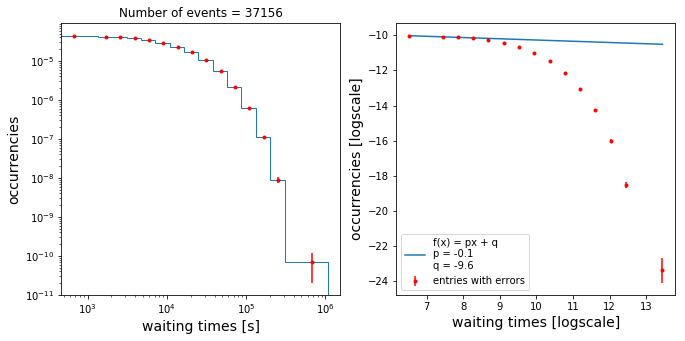


Time distribution for m =  2.2222222222222223 

Merging first and second bins.
Entered in the while loop
Original frequencies:  [2.078e+03 9.540e+02 1.271e+03 1.761e+03 2.250e+03 2.682e+03 3.132e+03
 3.101e+03 2.615e+03 2.006e+03 1.176e+03 4.740e+02 1.260e+02 2.100e+01
 2.000e+00 0.000e+00]
Merging bin 15 (empty) with bin 14.
Good points 4 out of 14


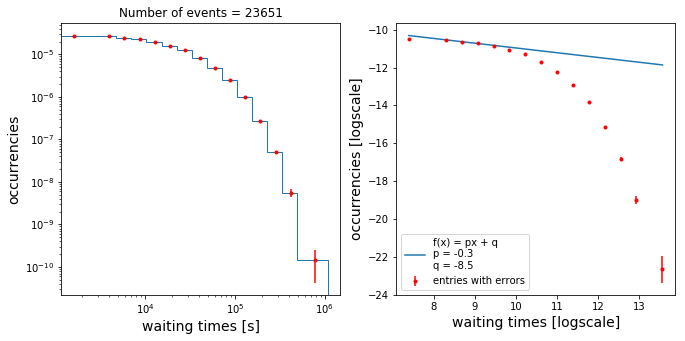


Time distribution for m =  2.4444444444444446 

Merging first and second bins.
Good points 3 out of 15


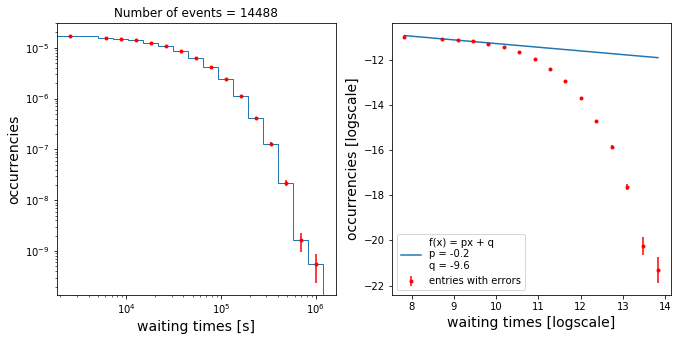


Time distribution for m =  2.6666666666666665 

Good points 3 out of 16


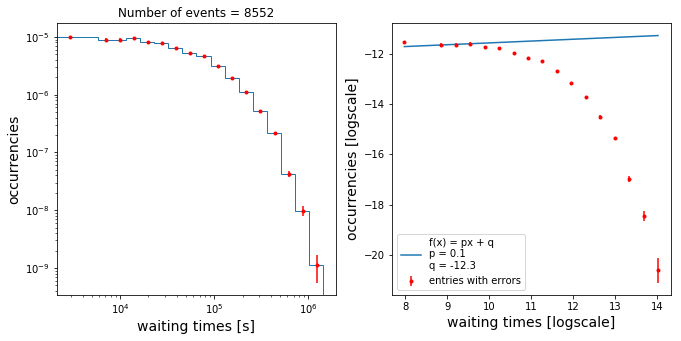


Time distribution for m =  2.888888888888889 

Good points 8 out of 15


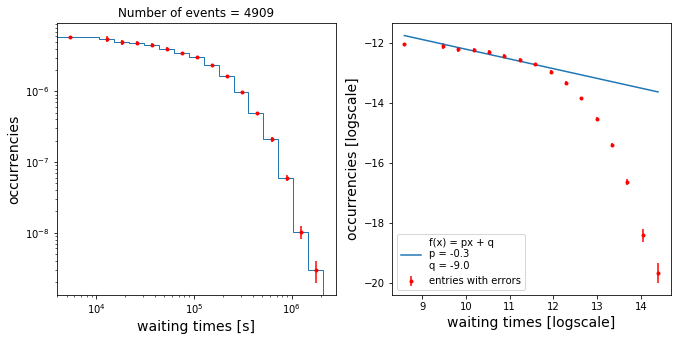


Time distribution for m =  3.111111111111111 

Good points 9 out of 14


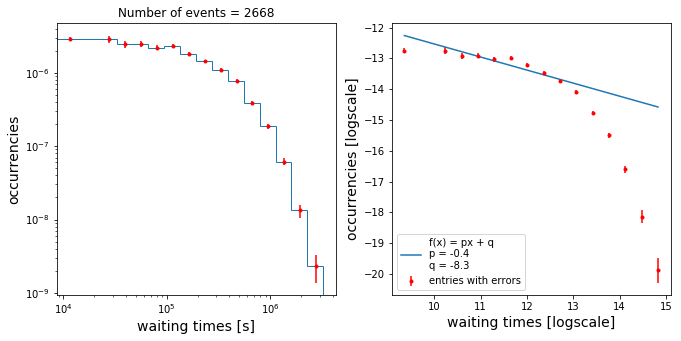


Time distribution for m =  3.333333333333333 

Good points 10 out of 13


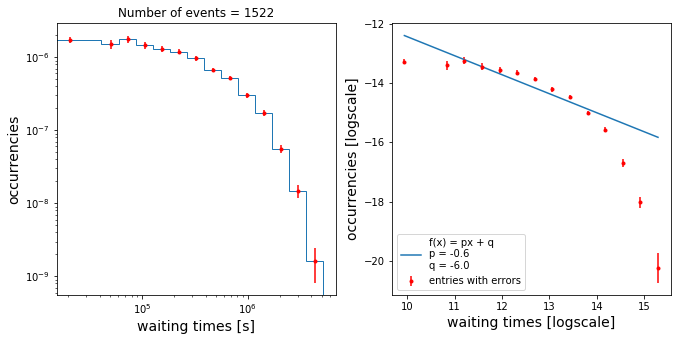


Time distribution for m =  3.5555555555555554 

Good points 3 out of 12


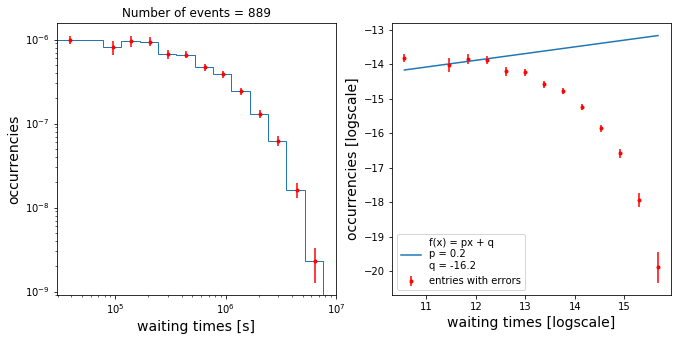


Time distribution for m =  3.7777777777777777 

Merging first and second bins.
Good points 7 out of 10


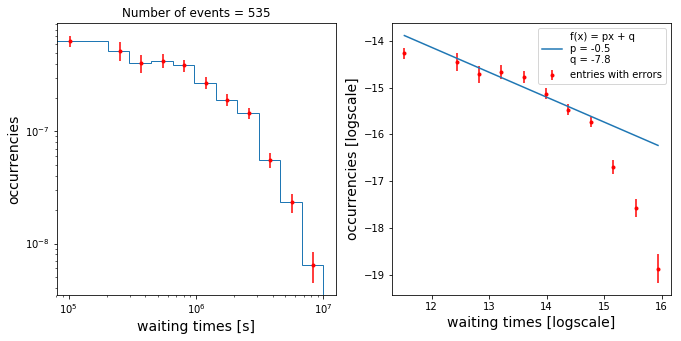


Time distribution for m =  4.0 

Good points 3 out of 10


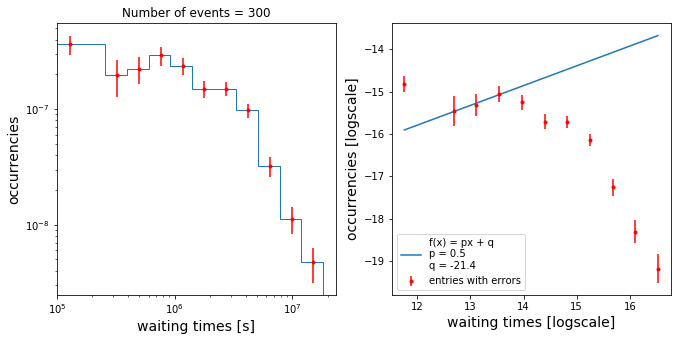

In [35]:
# REMOVE
# we choose to study the data for m between 2 and 4.5, because above 5 we get just 104 samples 
# and there isn't enough information to fit anything but the initial peak of the distribution.
ms = np.linspace(2,4,10)
p_time_prime = np.zeros(len(ms))
q_time_prime = np.zeros(len(ms))
p_t_errors_prime = np.zeros(len(ms))
cut_times_prime = np.zeros(len(ms))

for i in range(len(ms)):

    m = ms[i]
    print('\nTime distribution for m = ', m, '\n')
    # waiting time for events of magnitude > m
    dfm_pr = df[(df['magnitude'] > m) & (df['prev_event'] == -1)]
    timem = np.array(dfm_pr['time'])
    timem.sort()
    time_d = timem[1:] - timem[:-1]
    
    # eliminating a couple of anomalous events
    temp = time_d[time_d != time_d.max()]
    maximum = temp.max()
    if time_d.max()*3/4 > maximum:
        time_d = temp
# COULD BE INTERESTING, BUT IS AN EXTRA PART
    p_time_prime[i], q_time_prime[i], p_t_errors_prime[i], cut_times_prime[i] = plot_powerlaw_hist(time_d, rescaling = False, 
                                                                   density = True, cut_off = True, P0 = 3)

# 3 - Distance distribution between events

Compute the distribution $P_m(r)$ of the distance between an event and the next one, considering earthquakes of magnitude m or above. Also here make a clever choice for the bin sizes and try several values of $m$.

## NOTA
Qui potremmo menzionare il fatto che il binning con il metodo di sopra è completamente instabile, che si intravede un picco nella distribuzione, ma non si riescono ad avere un numero sufficiente di bin con una spaziatura adatta per visualizzare il massimo e contemporaneamente fittare separatamente il fronte di salita e discesa. Quindi abbiamo preferito tentare con una decomposizione delle distanze tra quelle di eventi primi e quelle di eventi conseguenti, rispettivamente con una poissoniana e con una powerlaw. In ogni caso le tre celle successive le rimuoverei a prescindere.

In [36]:
# REMOVE
def binning_dist(x, rescaling = False, density = False):
    
    """Binning for power laws distributions.
        x = entries generated from a power law."""
    
    # x must have streactly positive values; x isn't normalized in general
    x = x[x>0]
    if rescaling == True:
        x = x/x.max()
        
    x.sort()
    # empirical method to get a good amount of bins (min 8), depending on the number of samples
    bin_extremes_number = max( min( int( np.log(len(x)) ) , 21), 9) 
    print('Bin extremes number chosen: ', bin_extremes_number )
    first_quantile = x[int(x.shape[0]*(0.3/bin_extremes_number))]
    #print('First quantile: ', first_quantile)
    bin_extremes = np.logspace(np.log10(first_quantile), np.log10(x.max()), bin_extremes_number)
    bin_extremes = np.concatenate((np.array([0]), bin_extremes))

    widths = bin_extremes[1:] - bin_extremes[:-1]
    centers = (bin_extremes[1:] + bin_extremes[:-1])/2
    
    freq, _, _ = plt.hist(x, bins=bin_extremes)
    plt.close()
    
    # weights(bin_center) = Prob(bin_center) if normalized
    weights = freq/widths
    sigma_weights = np.sqrt(freq)/widths
    """
    # merging of the first two bins until we get that the first bin represents the max of the PDF
    while weights[0] < weights[1]:
        print('Merging first and second bins.')
        #this is done by removing the second extreme, thus the first bin becomes the one between 0 and 2
        bin_extremes = np.concatenate(([bin_extremes[0]], bin_extremes[2:] ))
        widths = bin_extremes[1:] - bin_extremes[:-1]
        centers = (bin_extremes[1:] + bin_extremes[:-1])/2

        freq, _, _ = plt.hist(x, bins=bin_extremes)
        plt.close()
        weights = freq/widths
        sigma_weights = np.sqrt(freq)/widths
    """  
    # adding also the merging of empty bins with the one on the left
    # rewrite it in a better form
    mask = (freq != np.zeros(len(freq)))
    flag = np.all(mask)
    print('All frequencies are non-zero : ', flag)
    # should enter in the while loop only in there is at least one bin without counts in it
    
    while flag == False:
        print('Entered in the while loop')
        print('Original frequencies: ', freq)
        for i in range(1,len(freq)):
            if freq[i] == 0:
                print('Merging bin {} (empty) with bin {}.'.format(i,i-1))
                # bin extremes should be of length len(freq) + 1
                # notice that bin_extremes[i] corresponds to the right border of bin[i-1]
                # bin_extremes[:i] excludes the bin_extreme[i] !
                bin_extremes = np.concatenate((bin_extremes[:i], bin_extremes[i+1:] ))
                widths = bin_extremes[1:] - bin_extremes[:-1]
                centers = (bin_extremes[1:] + bin_extremes[:-1])/2
                # call a break of the for because the len frequence changes and can result in index errors
                break
                
        # update of the frequencies

        freq, _, _ = plt.hist(x, bins=bin_extremes)
        plt.close()
        weights = freq/widths
        sigma_weights = np.sqrt(freq)/widths
        
        mask = (freq != np.zeros(len(freq)))
        flag = np.all(mask)
 
    if density == True:
        #returns normalized weights (with rescaled errors) so that the area of the histogram is 1
        area = np.sum(weights*widths)
        weights = weights / area
        sigma_weights = sigma_weights/area
    
    return bin_extremes, widths, centers, freq, weights, sigma_weights   

In [37]:
# REMOVE
def plot_powerlaw_hist_distance(x, rescaling = False, density = False, **kwargs):
    
    bin_extremes, widths, centers, freq, weights, sigma_weights = binning_dist(x, rescaling, density)
    bin_number = len(centers)
    
    fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2,figsize=(11, 5))
        
    ax1.hist(centers, bins = bin_extremes, weights = weights, histtype = 'step')
    ax1.errorbar(centers, weights, sigma_weights, fmt = 'r.')
    ax1.set_xscale('log')
    #ax1.set_yscale('log')
    ax1.set_xlabel('distances [m]', fontsize = 14)
    ax1.set_ylabel('occurrencies', fontsize = 14)
    ax1.set_title('Number of events = {}'.format(len(x)))
    
    # now we need to fit the power law in the log-log space, eventually identifying the points before the cut-off
    # this should work automatically both for the case rescaling = True or False (if True, x is in [0,1]) 
    # and for the case density = True or False (if True, the area of the histogram is normalized to 1 
    # and the weights are rescaled so that np.sum(weights*bin_widths) = 1)
    log_x = np.log(centers)
    log_w = np.log(weights)
    
    # the idea is to write a function that as a default just fits the (log_x,log_w) with a linear function 
    # log_w = p*log_x + q and has 2 flags: one for excluding skip_initial_pt points (set to 1 for default because
    # the first bin is always problematic) and another one to signal that we expect a cut-off at the right side of the
    # distribution (i.e. the tail) and we want to stop fitting just before the cut-off.
    # we want as a return the parameters p and q with their covariance matrix (that is the default return of 
    # scipy curve_fit) and, if the cut_off flag is True, also the estimate cut-off (rescaled or not depending on the 
    # setting passed before)
    
    if 'cut_off' in kwargs:
        if kwargs['cut_off'] == True:
             p, q, cov, log_x_cut = loglog_fitting(log_x, log_w, **kwargs)
    else:
        p, q, cov = loglog_fitting(log_x, log_w, **kwargs)
    
    # those errors are wrong!
    #y_errors = 1./np.sqrt(weights)
    #should be
    y_errors = sigma_weights/weights
    
    ax2.errorbar(log_x, log_w, yerr = y_errors ,fmt ='r.', label = 'entries with errors')
    ax2.plot(log_x, linear_f(log_x, p, q), 
             label = 'f(x) = px + q\np = {} \nq = {}'.format(round(p,1),round(q,1)))
    ax2.legend()
    ax2.set_xlabel('distances [logscale]', fontsize = 14)
    ax2.set_ylabel('occurrencies [logscale]', fontsize = 14)
    
    plt.show()
    
    if 'cut_off' in kwargs:
        if kwargs['cut_off'] == True:
            if rescaling == True:
                return p, q, np.sqrt(cov[0,0]), np.exp(log_x_cut)*x.max()
            else:
                return p, q, np.sqrt(cov[0,0]), np.exp(log_x_cut)
    else:
        # returns the slope, the intercept and the error of the slope
        return p, q, np.sqrt(cov[0,0])


Distance distribution for m =  2.0 

Bin extremes number chosen:  10
All frequencies are non-zero :  True
Good points 6 out of 9


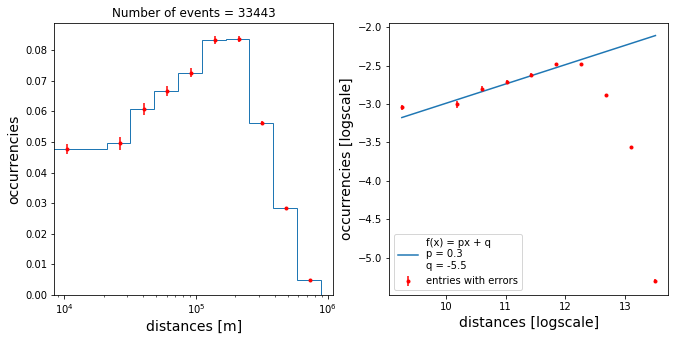


Distance distribution for m =  2.4 

Bin extremes number chosen:  9
All frequencies are non-zero :  True
Good points 6 out of 8


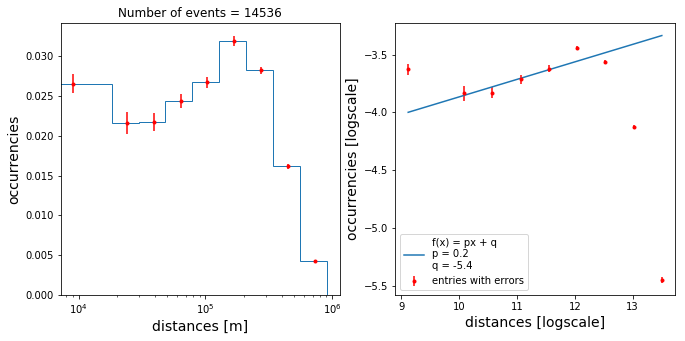


Distance distribution for m =  2.8 

Bin extremes number chosen:  9
All frequencies are non-zero :  True
Good points 7 out of 8


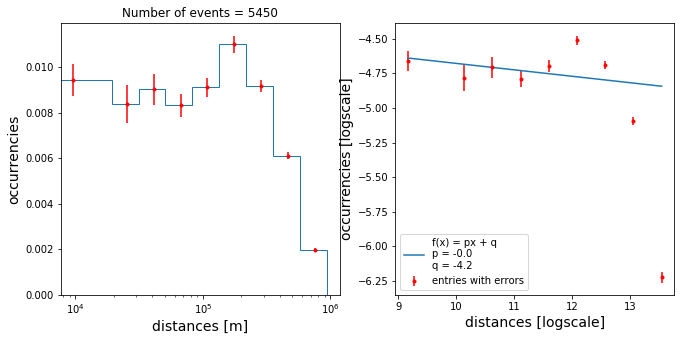


Distance distribution for m =  3.2 

Bin extremes number chosen:  9
All frequencies are non-zero :  True
Good points 7 out of 8


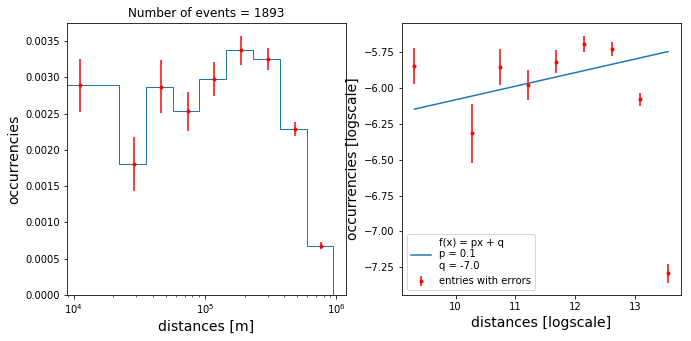


Distance distribution for m =  3.6 

Bin extremes number chosen:  9
All frequencies are non-zero :  True
Good points 7 out of 8


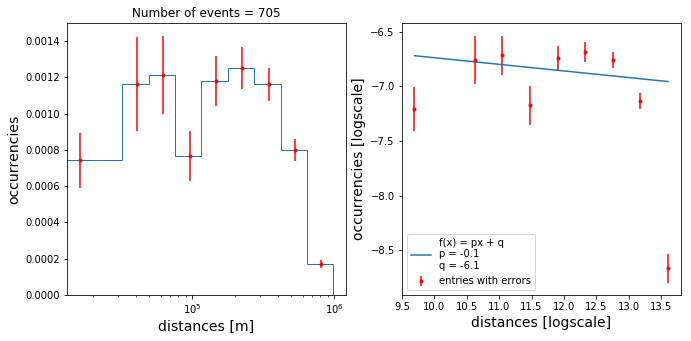


Distance distribution for m =  4.0 

Bin extremes number chosen:  9
All frequencies are non-zero :  True
Good points 7 out of 8


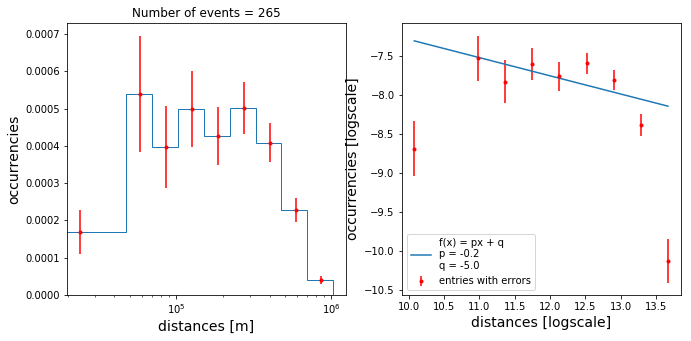

In [38]:
# REMOVE
ms = np.linspace(2,4,6)
p_dist = np.zeros(len(ms))
q_dist = np.zeros(len(ms))
p_d_errors = np.zeros(len(ms))
cut_dist = np.zeros(len(ms))


for i in range(len(ms)):
    m = ms[i]
    print('\nDistance distribution for m = ', m, '\n')
    prime_df = df[df['prev_event'] == -1]
    dfm = prime_df[(prime_df['magnitude'] > m) & (prime_df['magnitude'] < m+1)]
    X = np.array(dfm[['x','y','z']])
    r = np.linalg.norm(X[1:]-X[:-1], axis = 1)
    p_dist[i], q_dist[i], p_d_errors[i], cut_dist[i] = plot_powerlaw_hist_distance(r, rescaling = False, 
                                                        density = False, cut_off = True)

In [39]:
def select_bin_number_mod(x, m = 2, min_nbin = 7, fraction = 0.001):
    """Starts from evenly separed bins and merges the last ones until the tail's counts are 
        major or equal to the 'fraction' of the total number of occurrencies, given the 
        constraint that the final number of bins has to be min_nbin."""
    
    # added a factor exp(m-2) to take into account the exponential decrease of total N - empirical formula
    n_min = max([int(fraction*len(x)*np.exp(m-2)),10])
    print('For m = {} and N = {} the minimum number of events in the tail required is : {}'.format(m, len(x), n_min))
    print('Minimum accuracy expected : {}'.format(round(1 - 1/np.sqrt(n_min),2)))
    
    n, bin_extremes, _ = plt.hist(x, bins = min_nbin )
    plt.close()
    last_n = n[-1]
    
    if last_n > n_min:
        return min_nbin, bin_extremes
    else:
        i = min_nbin 
        nbin = min_nbin
        while last_n < n_min and nbin < 100:
            nbin = nbin + 1
            n, _, _ = plt.hist(x, bins = nbin )
            plt.close()
            last_n = n[i-1:].sum()
        
        if last_n > n[min_nbin-2]:
            print('-> reducing the final number of bins to {}: \n'.format(min_nbin - 1))
            nbin, bins = select_bin_number_mod(x, m = m, min_nbin = min_nbin - 1)
        else:   
            n, bin_extremes, _ = plt.hist(x, bins = nbin )
            plt.close()
            bins = np.concatenate((bin_extremes[:min_nbin],bin_extremes[-1:]))
        
        return nbin, bins

In [40]:
def plot_Pm_r2(m, df):
    print('\nDistance distribution for m = ', m, '\n')
    dfm = df[df['magnitude'] > m]
    X = np.array(dfm[['x','y','z']])
    r = np.linalg.norm(X[1:]-X[:-1], axis = 1)
    r_norm = r/r.max()
    # computing suitable sizes of bins
    original_bin_number, bins = select_bin_number_mod(r_norm, m=m, min_nbin = 10)
    bin_number = len(bins) - 1
    
    fig, ax1 = plt.subplots(nrows=1, ncols=1,figsize=(6, 5))
    
    n_tailed, bin_extremes, _ = ax1.hist(r_norm, bins = bins, histtype = 'step')

    bin_centers = (bin_extremes[:-1] + bin_extremes[1:])/2
    
    # rescaling the tail entries with the number of bins merged into the tail 
    n = np.concatenate((n_tailed[:-1], n_tailed[-1:]/(original_bin_number+1-bin_number)))
    
    sigma_n = np.sqrt(n)
    
    ax1.errorbar(bin_centers, n, sigma_n, fmt = 'r.')
    ax1.set_xlabel('normalized distances', fontsize = 14)
    ax1.set_ylabel('occurrencies', fontsize = 14)
    ax1.set_title('Number of events = {}'.format(len(r_norm)))

    plt.show()
    plt.close()
    return r.mean(), r.std()/np.sqrt(len(r))


Distance distribution for m =  2.0 

For m = 2.0 and N = 106197 the minimum number of events in the tail required is : 106
Minimum accuracy expected : 0.9


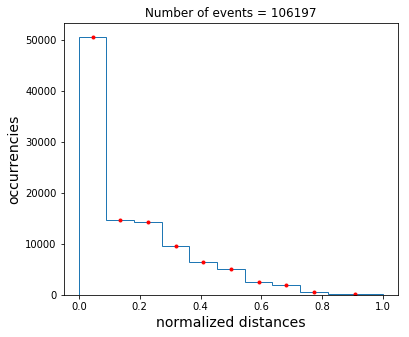


Distance distribution for m =  2.5 

For m = 2.5 and N = 37621 the minimum number of events in the tail required is : 62
Minimum accuracy expected : 0.87


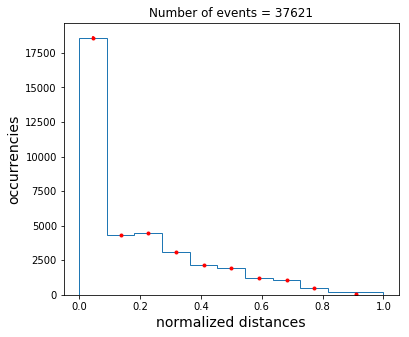


Distance distribution for m =  3.0 

For m = 3.0 and N = 11457 the minimum number of events in the tail required is : 31
Minimum accuracy expected : 0.82


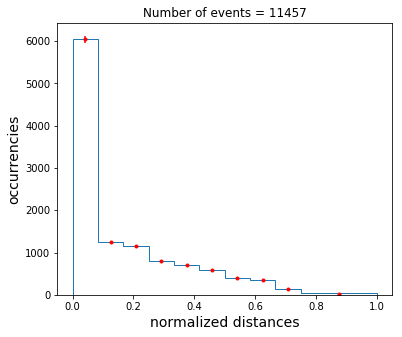


Distance distribution for m =  3.5 

For m = 3.5 and N = 3526 the minimum number of events in the tail required is : 15
Minimum accuracy expected : 0.74


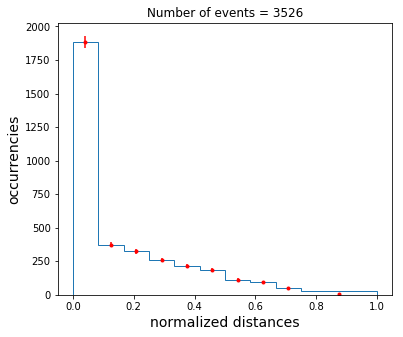


Distance distribution for m =  4.0 

For m = 4.0 and N = 1099 the minimum number of events in the tail required is : 10
Minimum accuracy expected : 0.68


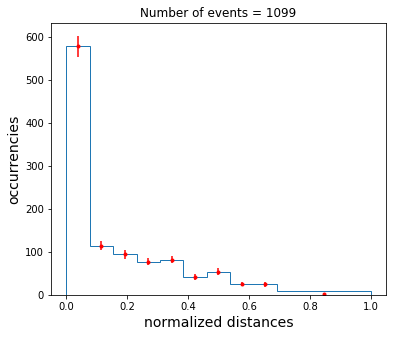


Distance distribution for m =  4.5 

For m = 4.5 and N = 350 the minimum number of events in the tail required is : 10
Minimum accuracy expected : 0.68
-> reducing the final number of bins to 9: 

For m = 4.5 and N = 350 the minimum number of events in the tail required is : 10
Minimum accuracy expected : 0.68
-> reducing the final number of bins to 8: 

For m = 4.5 and N = 350 the minimum number of events in the tail required is : 10
Minimum accuracy expected : 0.68
-> reducing the final number of bins to 7: 

For m = 4.5 and N = 350 the minimum number of events in the tail required is : 10
Minimum accuracy expected : 0.68
-> reducing the final number of bins to 6: 

For m = 4.5 and N = 350 the minimum number of events in the tail required is : 10
Minimum accuracy expected : 0.68
-> reducing the final number of bins to 5: 

For m = 4.5 and N = 350 the minimum number of events in the tail required is : 10
Minimum accuracy expected : 0.68


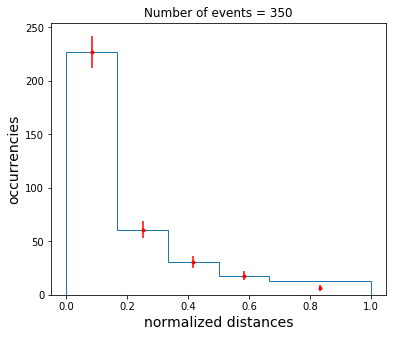

In [41]:
ms = np.linspace(2,4.5,6)

r_mean = np.zeros(len(ms))
r_std = np.zeros(len(ms))

for i in range(len(ms)):
    m = ms[i]
    r_mean[i], r_std[i] = plot_Pm_r2(m, df)

## Distance distribution decomposition

The distributions that can be seen above can't be easily identified with a known distribution, thus we decomposed it in two different contributions using our knowledge about how the earthquakes relate one to each other. In fact they can be studied as a sequence of independent events (the ones with prev_event = -1), each one of them causing a cluster of related events, as we have already seen in the study of the tree architecture of the dataset.

Thus we expect that the overall distance distribution is the result of the following process:
* each earthquake has a magnitude distributed as $P(m) \propto e^{-am}$, $a > 0$;
* each earthquake causes N events depending on his magnitude with distibution $N(m) = N_0e^{\gamma m}$, $\gamma > 0$;
* prime events are independent one from another and are distributed with a certain distance distribution $P'_m(r)$;
* consequent events (i.e. all the events that are not prime) have a distance r from the event that caused them, that is distributed with another distribution $P^{cons}(r)$ (here we drop the m-dependence, because a threshold on m is going to breake the chain of cause-effect, that is univoque);

This four distributions, if known, could reproduce the probability distribution of the distance between two "following" events; thus in this section we are going to study $P'_m(r)$ and $P^{cons}(r).$

## 3.1 - Distance distribution between prime events

In [42]:
def poissonian4(x, A=1, l=1):
    from scipy.special import gamma
    return A*np.float_power(l,x)/gamma(x)*np.exp(-l)

import scipy.stats as st
from scipy.integrate import quad

class my_pdf(st.rv_continuous):
    def _pdf(self,x, A, l):
        return poissonian4(x, A, l)  # Normalized over its range, in this case [0,1]

In [80]:
def plot_Pm_r_poisson(m, df):
    print('\nDistance distribution for m = ', m, '\n')
    dfm = df[df['magnitude'] > m]
    X = np.array(dfm[['x','y','z']])
    r = np.linalg.norm(X[1:]-X[:-1], axis = 1)
    r_norm = r/r.max()
    
    
    # computing suitable sizes of bins
    original_bin_number, bins = select_bin_number_mod(r_norm, m=m, min_nbin = 10)
    
    bin_number = len(bins) - 1
    
    fig, ax1 = plt.subplots(nrows=1, ncols=1,figsize=(6, 5))
    
    n_tailed, bin_extremes, _  = ax1.hist(r_norm, bins = bins, histtype = 'step', density=True)
    
    bin_centers = (bin_extremes[:-1] + bin_extremes[1:])/2
    area = len(r)*(bin_extremes[1] - bin_extremes[0])
    # rescaling the tail entries with the number of bins merged into the tail 
    n = np.concatenate((n_tailed[:-1], n_tailed[-1:]/(original_bin_number+1-bin_number)))
    
    sigma_n = np.sqrt(n/area)
    ax1.errorbar(bin_centers, n, sigma_n, fmt = 'r.', label = 'entries with \npoissonian errors')
    ax1.set_xlabel('normalized distances', fontsize = 14)
    ax1.set_ylabel('occurrencies', fontsize = 14)
    ax1.set_title('Number of events = {}'.format(len(r_norm)))
    
    print('Number of bins merged into the tail: {}'.format(original_bin_number - bin_number), '\n')

    #print('bin_centers: ', bin_centers, '\n')
    params1, cov1 = optimize.curve_fit(poissonian4, bin_centers, n, p0 = [n[0], 1])
    [A,l] = params1
    
    # tecnical stuff to create a continuous probability distribution in scipy, that allows for the method .expect
    # to compute the expected value of the distribution; the origin of the complication is the fact that poissonians
    # usually are discrete and in the continuous case the the parameter lambda doesn't represent anymore the expected value
    Area = quad(poissonian4, 0, 1, args=(A, l))[0]
    my_cv = my_pdf(a=0, b=1)
    
    C = A/Area
    
    x_axis = np.linspace(bin_extremes[0], bin_extremes[-1],100)
    ax1.plot(x_axis, my_cv.pdf(x_axis, A=C, l=l), label = 'poissonian \n $\lambda$ = %.3f '%l)
    x_expected = my_cv.expect(args=(C, l))
    x_err = r_norm.std()/np.sqrt(len(r))
    ax1.axvline(x_expected, label = 'expected value = %.2f'%x_expected)
    
    ax1.legend()
    plt.show()
    plt.close()
    
    # parameters of the poissonian, expected value, error of the mean, max distance for scaling back normalized distances
    return C, l, x_expected, x_err, r.max()

We plotted for each magnitude the normalized distances between two events and fitted them with a continuous Poisson distribution, that is usually used for independent event with a well-defined expected value.


Distance distribution for m =  2.0 

For m = 2.0 and N = 37157 the minimum number of events in the tail required is : 37
Minimum accuracy expected : 0.84
Number of bins merged into the tail: 1 

bin_centers:  [0.04546371 0.13637193 0.22728015 0.31818836 0.40909658 0.5000048
 0.59091302 0.68182124 0.77272945 0.90909178] 



/home/nicola/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: RuntimeWarning: invalid value encountered in float_power
  This is separate from the ipykernel package so we can avoid doing imports until


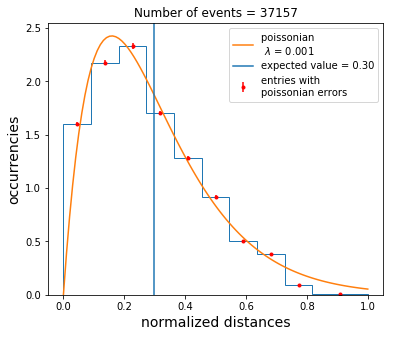


Distance distribution for m =  2.25 

For m = 2.25 and N = 22268 the minimum number of events in the tail required is : 28
Minimum accuracy expected : 0.81
Number of bins merged into the tail: 1 

bin_centers:  [0.04546371 0.13637193 0.22728015 0.31818836 0.40909658 0.5000048
 0.59091302 0.68182124 0.77272945 0.90909178] 



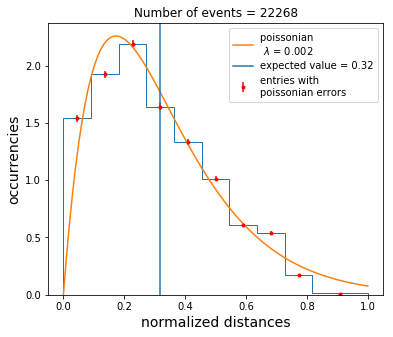


Distance distribution for m =  2.5 

For m = 2.5 and N = 12482 the minimum number of events in the tail required is : 20
Minimum accuracy expected : 0.78
Number of bins merged into the tail: 1 

bin_centers:  [0.0455508  0.13645072 0.22735065 0.31825057 0.40915049 0.50005042
 0.59095034 0.68185027 0.77275019 0.90910008] 



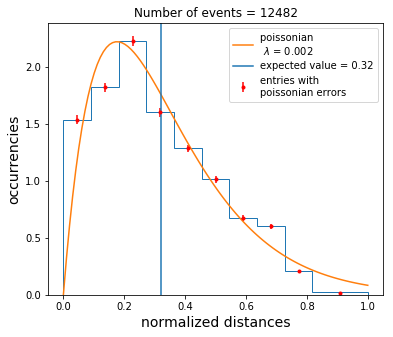


Distance distribution for m =  2.75 

For m = 2.75 and N = 6848 the minimum number of events in the tail required is : 14
Minimum accuracy expected : 0.73
Number of bins merged into the tail: 1 

bin_centers:  [0.04574358 0.13662514 0.2275067  0.31838827 0.40926983 0.5001514
 0.59103296 0.68191453 0.77279609 0.90911844] 



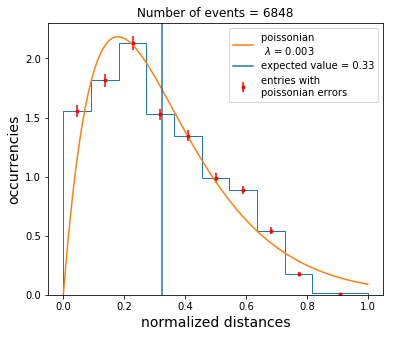


Distance distribution for m =  3.0 

For m = 3.0 and N = 3567 the minimum number of events in the tail required is : 10
Minimum accuracy expected : 0.68
Number of bins merged into the tail: 1 

bin_centers:  [0.04574358 0.13662514 0.2275067  0.31838827 0.40926983 0.5001514
 0.59103296 0.68191453 0.77279609 0.90911844] 



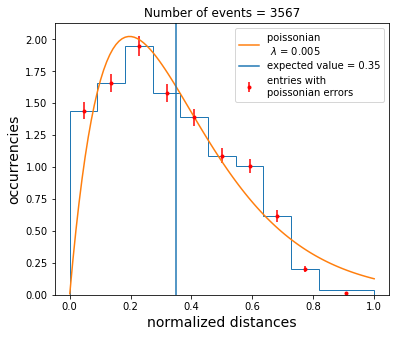


Distance distribution for m =  3.25 

For m = 3.25 and N = 1866 the minimum number of events in the tail required is : 10
Minimum accuracy expected : 0.68
Number of bins merged into the tail: 1 

bin_centers:  [0.04618399 0.13702361 0.22786323 0.31870285 0.40954247 0.50038209
 0.59122171 0.68206133 0.77290095 0.90916038] 



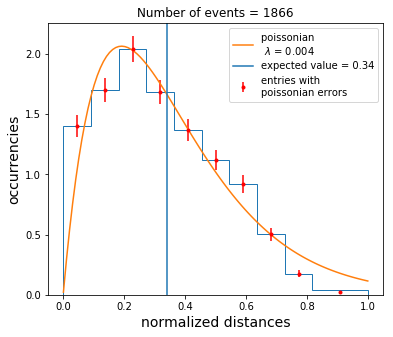


Distance distribution for m =  3.5 

For m = 3.5 and N = 993 the minimum number of events in the tail required is : 10
Minimum accuracy expected : 0.68
Number of bins merged into the tail: 1 

bin_centers:  [0.04966685 0.14017477 0.23068269 0.32119061 0.41169853 0.50220645
 0.59271437 0.68322228 0.7737302  0.90949208] 



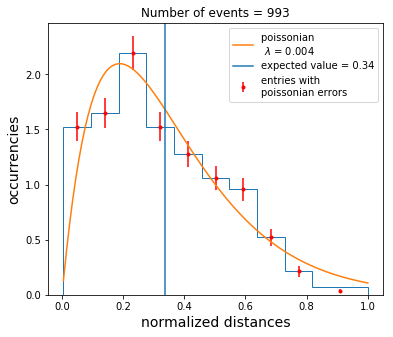


Distance distribution for m =  3.75 

For m = 3.75 and N = 555 the minimum number of events in the tail required is : 10
Minimum accuracy expected : 0.68
Number of bins merged into the tail: 2 

bin_centers:  [0.04656914 0.12947617 0.2123832  0.29529023 0.37819726 0.4611043
 0.54401133 0.62691836 0.70982539 0.87563945] 



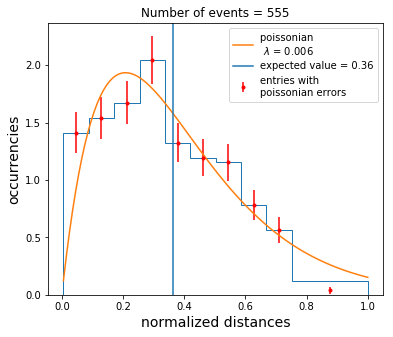


Distance distribution for m =  4.0 

For m = 4.0 and N = 300 the minimum number of events in the tail required is : 10
Minimum accuracy expected : 0.68
Number of bins merged into the tail: 3 

bin_centers:  [0.05138108 0.1272706  0.20316011 0.27904962 0.35493914 0.43082865
 0.50671816 0.58260768 0.65849719 0.84822097] 



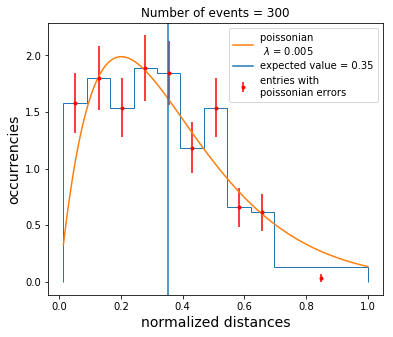

In [44]:
prime_df = df[df['prev_event'] == -1]
# reduced the range of m to [2,4] due to insufficient samples for higher magnitudes
pr_ms = np.linspace(2,4,9)

pr_Cs = np.zeros(len(pr_ms))
pr_ls_r = np.zeros(len(pr_ms))
pr_r_expected = np.zeros(len(pr_ms))
pr_r_exp_err = np.zeros(len(pr_ms))
pr_r_max = np.zeros(len(pr_ms))


for i in range(len(pr_ms)):
    m = pr_ms[i]
    pr_Cs[i], pr_ls_r[i], pr_r_expected[i], pr_r_exp_err[i], pr_r_max[i] = plot_Pm_r_poisson(m, prime_df)

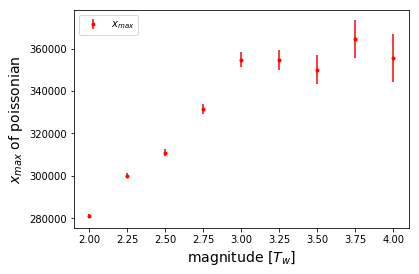

In [45]:
rescaled_peaks = pr_r_expected*pr_r_max
rescaled_errors = pr_r_exp_err*pr_r_max
plt.errorbar(pr_ms, rescaled_peaks, rescaled_errors, fmt = 'r.', label = '$x_{max}$')
plt.xlabel('magnitude [$T_w$]', fontsize = 14)
plt.ylabel('$x_{max}$ of poissonian', fontsize = 14)
plt.legend(loc = 2)
plt.show()

In the graph we can see that the expected value of the distance between two events grows linearly as a function of the magnitude until $m = 3.0$, where there is a plateau, indicating some kind of saturation effect. 

## 3.2 - Distance distribution between consequent events

In [46]:
distance_tree = np.zeros(N)

for d in range(len(v_dict)):
    for k in v_dict[d].keys():
        # previous vertex has id = k, children vertexes have ids [ v_dict[d][k] ]
        for j in v_dict[d][k]:
            distance_tree[int(j)] = np.linalg.norm(df[['x','y','z']].iloc[int(j)] - df[['x','y','z']].iloc[int(k)])
            
distance_tree = distance_tree[distance_tree > 0]

In the panels below we can see that for consequent events we find once again a powerlaw with a cut-off, just like in the waiting times distribution, even though in this case our analysis can't be performed for all the magnitudes, because this would break the chain of cause-effect that is necessary to the algorithm itself to compute the waiting times.

Merging first and second bins.
Good points 10 out of 15


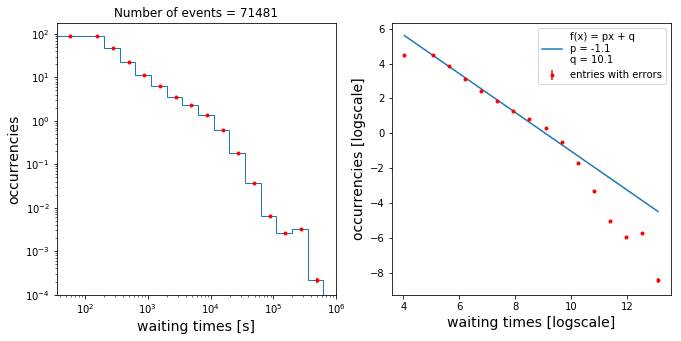

(-1.1142523298314724, 10.10819168141148, 0.04061575257050637, 36721.5670592461)

In [49]:
plot_powerlaw_hist(distance_tree, rescaling = False, density = False, cut_off = True)

## 4 - Range-conditioned waiting time distribution

Compute the distribution $P_{m,R}(t)$ of waiting times for events of magnitude $m$ or above, which are separated by at most a distance $r<R$, for different values of m and $R$. (In this statistics, if the following event is farther than $R$, skip the $t$ and go to the next pair)

In our analysis we choose to analyze the waiting times distribution for different areas around n fixed centers (uniformly distributed in the plane identified with the PCA procedure).
We proceed as follows: 
* we filter the dataset with the threshold magnitude > m;
* for each center $C_i$ and each radius $r_j$ (expressed in fractions of the maximum distance between two events in the dataset) we select only the events whose normalized distance (w.r.t the max distance) from $C_i$ is less than $r_j$; 
* we compute the waiting times from each event to the one among the remaining that comes right after it (again this is done for n centers and for each radius)
* we make a histogram using all the waiting times for a given radius and ALL centers (in this way the resulting distribution is a kind of mean among all centers) and study it as a powerlaw with cutoff (after all is derived from the waiting time distribution seen above, that is a powerlaw with cutoff too)

In [54]:
def plot_PmR_t(df, m, Rs, n=100, **kwargs):
    print('\nTime distribution for m = ', m, '\n')
    # waiting time for events of magnitude > m
    #Xp = np.dot(Vt,X) # last coordinate should be small
    #Xpp = np.dot(U, Xp)
    centers = np.dot(U, np.array([np.random.uniform(-3,4, n), np.random.uniform(-2,2, n), np.zeros(n)])).T
    dfm = df[df['magnitude'] > m]

    X = dfm[['x','y','z']].values.T
    X = X.astype("float64")
    # centering and rescaling the coordinates
    for i in range(3):
        X[i] = (X[i] - X[i].mean())/X[i].std()

    distances = np.linalg.norm((X.T[:,np.newaxis,:] - centers[np.newaxis,:,:]), axis=2)
    distances = distances / distances.max()
    print("Max distance : ", distances.max())
    timem = np.array(dfm['time'])
    timeM = np.tile(timem[:, np.newaxis], [1,n]).T
    
    #vector for fit parameters for each R_max fraction
    ps = []
    qs = []
    p_errors = [] 
    cut_off_times = []
    
    for i in range(len(Rs)):
        #print(timeM.shape)

        timeM_filtered = timeM[distances.T < Rs[i]]
        #print(timeM.shape)
        #print(distances.T.shape)
        time_d = (timeM_filtered[1:] - timeM_filtered[:-1])
        time_d = time_d[time_d>0]
        
        p, q, p_err, cut_times = plot_powerlaw_hist(time_d, **kwargs )
        
        ps.append(p); qs.append(q); p_errors.append(p_err), cut_off_times.append(cut_times)
        
    return ps, qs, p_errors, cut_off_times

In [55]:
from tqdm import tqdm_notebook, tnrange
import time
R_fractions = 20
ms = np.arange(2,4.6,0.1)
Rs = np.power(np.linspace(np.sqrt(0.1),1,R_fractions),2)
Ps = np.zeros((len(ms),R_fractions))
Qs = np.zeros((len(ms),R_fractions))
P_errors = np.zeros((len(ms),R_fractions))
t_cutoff = np.zeros((len(ms),R_fractions))

for i in tnrange(len(ms)):
    
    Ps[i], Qs[i], P_errors[i], t_cutoff[i] = plot_PmR_t(df, ms[i], Rs, cut_off = True, P0 = 5, show = False )


Time distribution for m =  2.0 

Max distance :  1.0
Good points 8 out of 16
Good points 8 out of 16
Good points 8 out of 16
Good points 8 out of 16
Good points 8 out of 16
Good points 10 out of 16
Good points 10 out of 16
Good points 11 out of 16
Good points 11 out of 16
Good points 11 out of 16
Good points 11 out of 16
Good points 11 out of 16
Good points 10 out of 16
Good points 10 out of 16
Good points 10 out of 16
Good points 14 out of 16
Entered in the while loop
Original frequencies:  [ 619236.  437973.  587917.  719160.  802496.  871035.  978949. 1120423.
 1226845. 1239990. 1029555.  618791.  231645.   42058.    1863.       0.
       0.]
Merging bin 15 (empty) with bin 14.
Entered in the while loop
Original frequencies:  [ 619236.  437973.  587917.  719160.  802496.  871035.  978949. 1120423.
 1226845. 1239990. 1029555.  618791.  231645.   42058.    1863.       0.]
Merging bin 15 (empty) with bin 14.
Good points 13 out of 14
Entered in the while loop
Original frequencies:  [ 6

Good points 10 out of 16
Good points 10 out of 16
Good points 11 out of 16
Good points 12 out of 16
Good points 12 out of 16
Good points 12 out of 16
Good points 12 out of 16
Good points 12 out of 16
Good points 12 out of 16
Good points 12 out of 16
Good points 12 out of 16
Good points 12 out of 16
Good points 12 out of 16
Good points 12 out of 16
Good points 13 out of 16
Good points 13 out of 16
Good points 13 out of 16

Time distribution for m =  2.8000000000000007 

Max distance :  1.0
Good points 10 out of 16
Good points 10 out of 16
Good points 10 out of 16
Good points 10 out of 16
Good points 11 out of 16
Good points 12 out of 16
Good points 12 out of 16
Good points 12 out of 16
Good points 12 out of 16
Good points 12 out of 16
Good points 13 out of 16
Good points 12 out of 16
Good points 13 out of 16
Good points 13 out of 16
Good points 13 out of 16
Good points 13 out of 16
Good points 13 out of 16
Good points 13 out of 16
Good points 13 out of 16
Good points 13 out of 16

Time 

Good points 15 out of 16
Good points 15 out of 16
Good points 15 out of 16
Good points 15 out of 16

Time distribution for m =  4.200000000000002 

Max distance :  1.0
Good points 13 out of 15
Good points 14 out of 16
Good points 14 out of 16
Good points 14 out of 16
Good points 14 out of 16
Good points 14 out of 16
Good points 14 out of 16
Good points 14 out of 16
Good points 15 out of 16
Good points 14 out of 16
Good points 15 out of 16
Good points 15 out of 16
Good points 15 out of 16
Good points 15 out of 16
Good points 15 out of 16
Good points 15 out of 16
Good points 15 out of 16
Good points 15 out of 16
Good points 15 out of 16
Good points 15 out of 16

Time distribution for m =  4.3000000000000025 

Max distance :  1.0
Good points 14 out of 15
Good points 15 out of 16
Good points 15 out of 16
Good points 15 out of 16
Good points 15 out of 16
Good points 14 out of 16
Good points 14 out of 16
Good points 14 out of 16
Good points 14 out of 16
Good points 14 out of 16
Good points 1

From our analysis of the cutoff times at different radii and magnitudes we can see that there are two different trends: 
* the cutoff waiting time increases as the magnitude increases (as we saw before with the exponential dependence from m)
* the cutoff waiting time increases as the radius decreases

The second trend can be interpreted as the fact that background (uncorrelated) events are more rare if we reduce the area of study and this implies a longer correlation between earthquakes in a smaller area (if the magnitude is fixed).

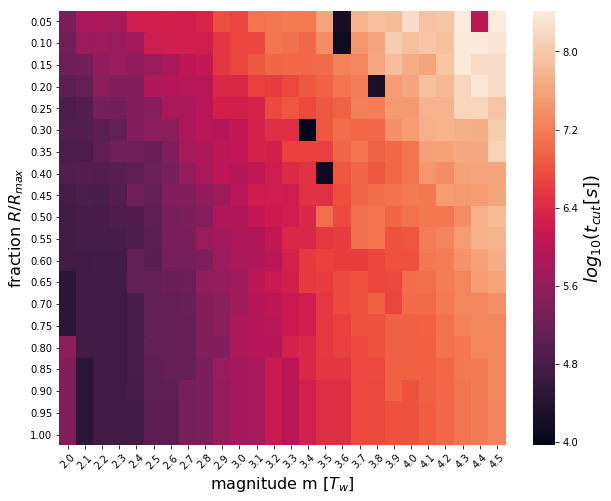

In [61]:
import seaborn as sns
plt.figure(figsize = (10,8))
ax = sns.heatmap(np.log10(t_cutoff).T, annot = False, cbar_kws = {'label' : '$log_{10}(t_{cut}[s]) $'})

m_index = ['%.1f'%m for m in ms]
ax.set_xticklabels(m_index, rotation = 45)
ax.set_xlabel('magnitude m [$T_w$]', fontsize = 16)

R_index = ['%.2f'%((i+1)/20) for i in range(len(Rs))]
ax.set_yticklabels(R_index, rotation = 0)
ax.set_ylabel('fraction $R/R_{max}$', fontsize = 16)

ax.figure.axes[-1].yaxis.label.set_size(18)

plt.show()

# 5 - Scaling properties
Eventually note if, from the analysis of the previous points, there emerges a scaling picture. Is there a suitable rescaling that collapses distributions for various $m$ (and eventually $R$ if point 4 is considered) on a single curve?

## 5.1 - Time scaling with magnitude

In [62]:
def collapsed_distributions(x, rescaling = False, density = False, show = True, **kwargs):
    
    bin_extremes, widths, centers, freq, weights, sigma_weights = binning(x, rescaling, density)
    bin_number = len(centers)
    
    if show:
        fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2,figsize=(11, 5))

        ax1.hist(centers, bins = bin_extremes, weights = weights, histtype = 'step')
        ax1.errorbar(centers, weights, sigma_weights, fmt = 'r.')
        ax1.set_xscale('log')
        ax1.set_yscale('log')
        ax1.set_xlabel('waiting times [s]', fontsize = 14)
        ax1.set_ylabel('occurrencies', fontsize = 14)
        ax1.set_title('Number of events = {}'.format(len(x)))
    
    # now we need to fit the power law in the log-log space, eventually identifying the points before the cut-off
    # this should work automatically both for the case rescaling = True or False (if True, x is in [0,1]) 
    # and for the case density = True or False (if True, the area of the histogram is normalized to 1 
    # and the weights are rescaled so that np.sum(weights*bin_widths) = 1)
    log_x = np.log(centers)
    log_w = np.log(weights)
    
    # the idea is to write a function that as a default just fits the (log_x,log_w) with a linear function 
    # log_w = p*log_x + q and has 2 flags: one for excluding skip_initial_pt points (set to 1 for default because
    # the first bin is always problematic) and another one to signal that we expect a cut-off at the right side of the
    # distribution (i.e. the tail) and we want to stop fitting just before the cut-off.
    # we want as a return the parameters p and q with their covariance matrix (that is the default return of 
    # scipy curve_fit) and, if the cut_off flag is True, also the estimate cut-off (rescaled or not depending on the 
    # setting passed before)
    
    if 'cut_off' in kwargs:
        if kwargs['cut_off'] == True:
             p, q, cov, log_x_cut = loglog_fitting(log_x, log_w, **kwargs)
    else:
        p, q, cov = loglog_fitting(log_x, log_w, **kwargs)
    
    if show:
        y_errors = sigma_weights/weights

        ax2.errorbar(log_x, log_w, yerr = y_errors ,fmt ='r.', label = 'entries with errors')
        ax2.plot(log_x, linear_f(log_x, p, q), 
                 label = 'f(x) = px + q\np = {} \nq = {}'.format(round(p,1),round(q,1)))
        ax2.legend()
        ax2.set_xlabel('waiting times [logscale]', fontsize = 14)
        ax2.set_ylabel('occurrencies [logscale]', fontsize = 14)

        plt.show()
    
    if 'cut_off' in kwargs:
        if kwargs['cut_off'] == True:
            if rescaling == True:
                return p, q, np.sqrt(cov[0,0]), np.exp(log_x_cut)*x.max()
            else:
                return p, q, np.sqrt(cov[0,0]), np.exp(log_x_cut)
    else:
        # returns the slope, the intercept and the error of the slope
        return p, q, np.sqrt(cov[0,0])

As we anticipated before, if for each magnitude we divide all the time intervals for the correspondent cutoff time (and we rescale the weights multiplying by the cutoff, in order to preserve the normalization of each histogram) we obtain a unique powerlaw with cutoff independent from the magnitude. 

This means that the system has a scaling property that binds waiting times and magnitudes in a unique way.

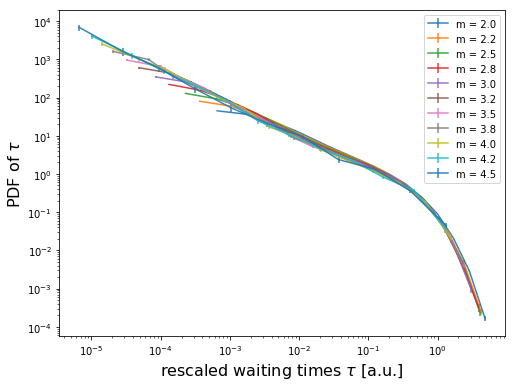

In [64]:
m_extremes= []
m_centers = []
m_weights =[]
m_sigma= []


for i in range(len(ms1)):

    m = ms1[i]
    dfm = df[df['magnitude'] > m]
    timem = np.array(dfm['time'])
    timem.sort()
    time_d = timem[1:] - timem[:-1]
    
    # eliminating a couple of anomalous events
    temp = time_d[time_d != time_d.max()]
    maximum = temp.max()
    if time_d.max()*3/4 > maximum:
        time_d = temp

    bin_extremes, widths, centers, freq, weights, sigma_weights = binning(time_d, rescaling = False, density = True)
    m_extremes.append(bin_extremes)
    m_centers.append(centers)
    m_weights.append(weights)
    m_sigma.append(sigma_weights)
    
extremes_rescaled = []  
centers_rescaled = []
weights_rescaled =[]
sigma_rescaled = []
widths_rescaled = []

plt.figure(figsize = (8,6))
for i in range(len(ms1)):
    resc_extremes      = m_extremes[i] / predicted_cut_times[i]; extremes_rescaled.append(resc_extremes)
    resc_centers       = m_centers[i] / predicted_cut_times[i];  centers_rescaled.append(resc_centers)
    resc_weights       = m_weights[i] * predicted_cut_times[i];  weights_rescaled.append(resc_weights)
    resc_sigma_weights = m_sigma[i] * predicted_cut_times[i];    sigma_rescaled.append(resc_sigma_weights)
    resc_widths        = resc_extremes[1:] - resc_extremes[:-1]; widths_rescaled.append(resc_widths)
    
    #centers = m_centers_rescaled[i]/cut_times[i]
    #weights = m_weights_rescaled[i]*cut_times[i]
    #sigma_weights = m_sigma_rescaled[i]*cut_times[i]
    plt.errorbar(resc_centers, resc_weights, yerr = resc_sigma_weights, label = 'm = %.1f'%ms1[i], alpha = 0.9)
plt.xlabel('rescaled waiting times '+r'$\tau$'+' [a.u.]',  fontsize = 16)
plt.ylabel('PDF of '+r'$\tau$', fontsize = 16)
plt.xscale('log')
plt.yscale('log')
plt.legend()
plt.show()